# Davi Meran (dm5tv@virginia.edu) DS 5001 Spring 2023
# Final Project

In [ ]:
import pandas as pd
import numpy as np
import os
colors = "YlGnBu"

#from textimporter import TextImporter
#from langmod import NgramCounter, NgramLanguageModel
#from glob import glob
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#from textparser import TextParser

import seaborn as sns; sns.set()
import plotly_express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

import itertools
from scipy.linalg import eigh
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram
import sys

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from pandas import DataFrame as df

from sklearn.decomposition import PCA
from scipy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
warnings.filterwarnings('ignore')

from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from flask import Flask, send_file

In [3]:
# ! pip install sklearn

In [4]:
# %pip install nltk
# %pip install seaborn
# %pip install plotly_express
# %pip install scipy.spatial.distance
# %pip install scipy.cluster.hierarchy
# %pip install scipy.linalg
# %pip install scipy
# %pip install sklearn 
# %pip install sklearn.preprocessing
# %pip install plotly
# %pip install vaderSentiment
# %pip install
# %pip install
# %pip install

In [5]:
#OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
OHCO = ['chap_num', 'sent_num', 'token_num']

# Getting Lines

In [6]:
def readIn(filename):
    lines = [line.replace('­', '').strip() for line in open(filename, 'r') if (not line.startswith('Page |')) and (line.strip() != '')]
    t = pd.DataFrame({'line_str': lines})
    t.index.name = 'line_num'
    return t

In [7]:
LINES1 = readIn('hp1.txt')
LINES2 = readIn('hp2.txt')
LINES3 = readIn('hp3.txt')
LINES4 = readIn('hp4.txt')
LINES5 = readIn('hp5.txt')
LINES6 = readIn('hp6.txt')
LINES7 = readIn('hp7.txt')

In [8]:
LINES1.head()

,line_str
line_num,
0,CHAPTER 1
1,"Mr. and Mrs. Dursley, of number four, Privet D..."
2,"that they were perfectly normal, thank you ver..."
3,people you'd expect to be involved in anything...
4,Mr. Dursley was the director of a firm called ...


# Getting Chapters

In [9]:
def getLines(filename):
    chap_lines = filename.line_str.str.match(r"^\s*CHAPTER\s+(\d+)")
    chap_nums = [i+1 for i in range(filename.loc[chap_lines].shape[0])]
    filename.loc[chap_lines, 'chap_num'] = chap_nums
    filename.chap_num = filename.chap_num.ffill()
    filename = filename.dropna(subset=['chap_num'])
    filename = filename.loc[~chap_lines]
    filename.chap_num = filename.chap_num.astype('int')
    return filename

In [10]:
LINES1 = getLines(LINES1)
LINES2 = getLines(LINES2)
LINES3 = getLines(LINES3)
LINES4 = getLines(LINES4)
LINES5 = getLines(LINES5)
LINES6 = getLines(LINES6)
LINES7 = getLines(LINES7)

In [11]:
LINES5.head()

,line_str,chap_num
line_num,,
1,The hottest day of the summer so far was drawi...,1
2,and lawns that were once emerald green lay par...,1
3,been banned due to drought. Deprived of their ...,1
4,inhabitants of Privet Drive had retreated into...,1
5,wide in the hope of tempting in a nonexistent ...,1


## Split by chapter

In [12]:
CHAPS1 = LINES1.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS2 = LINES2.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS3 = LINES3.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS4 = LINES4.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS5 = LINES5.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS6 = LINES6.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
CHAPS7 = LINES7.groupby(OHCO[:1]).line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')


In [13]:
CHAPS1.head()

,chap_str
chap_num,
1,"Mr. and Mrs. Dursley, of number four, Privet D..."
2,Nearly ten years had passed since the Dursleys...
3,The escape of the Brazilian boa constrictor ea...
4,BOOM. They knocked again. Dudley jerked awake....
5,Harry woke early the next morning. Although he...


## Split by paragraph

PARAS = CHAPS1['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str').sort_index()
PARAS.index.names = OHCO[:2] 
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')]
PARAS.head()

## Split by sentence

In [14]:
def getSents(filename):
    SENTS = filename['chap_str'].str.split(r'[.?!;:"]+', expand=True).stack().to_frame().rename(columns={0:'sent_str'})
    SENTS.index.names = OHCO[:2]
    SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')]
    SENTS.sent_str = SENTS.sent_str.str.strip()
    return SENTS


In [15]:
SENTS1 = getSents(CHAPS1)
SENTS2 = getSents(CHAPS2)
SENTS3 = getSents(CHAPS3)
SENTS4 = getSents(CHAPS4)
SENTS5 = getSents(CHAPS5)
SENTS6 = getSents(CHAPS6)
SENTS7 = getSents(CHAPS7)

In [16]:
SENTS1.head()

sent_str
chap_num sent_num                                                   
1        0                                                        Mr
         1                                                   and Mrs
         2         Dursley, of number four, Privet Drive, were pr...
         3         They were the last\npeople you'd expect to be ...
         4                                                        Mr

## Split by token

In [17]:
def getToks(filename): 
    TOKENS = filename['sent_str'].str.split(r"[\s',-]+", expand=True).stack()\
        .to_frame('token_str')
    TOKENS.index.names = OHCO[:4]
    TOKENS['term_str'] = TOKENS.token_str.str.replace(r"[\W_]+", '', regex=True).str.lower()
    return TOKENS


In [18]:
TOKENS1 = getToks(SENTS1)
TOKENS2 = getToks(SENTS2)
TOKENS3 = getToks(SENTS3)
TOKENS4 = getToks(SENTS4)
TOKENS5 = getToks(SENTS5)
TOKENS6 = getToks(SENTS6)
TOKENS7 = getToks(SENTS7)

In [19]:
TOKENS1.head()

token_str term_str
chap_num sent_num token_num                   
1        0        0                Mr       mr
         1        0               and      and
                  1               Mrs      mrs
         2        0           Dursley  dursley
                  1                of       of

# Combine all 7 books into Corpus

In [20]:
TOKENS1['book_id'] = "Sorcerer's Stone"
TOKENS2['book_id'] = "Chamber of Secrets"
TOKENS3['book_id'] = "Prisoner of Azkaban"
TOKENS4['book_id'] = "Goblet of Fire"
TOKENS5['book_id'] = "Order of the Phoenix"
TOKENS6['book_id'] = "Half-Blood Prince"
TOKENS7['book_id'] = "Deathly Hallows"

tok1 = TOKENS1.copy()
tok2 = TOKENS2.copy()
tok3 = TOKENS3.copy()
tok4 = TOKENS4.copy()
tok5 = TOKENS5.copy()
tok6 = TOKENS6.copy()
tok7 = TOKENS7.copy()

tok1.reset_index(inplace=True)
tok2.reset_index(inplace=True)
tok3.reset_index(inplace=True)
tok4.reset_index(inplace=True)
tok5.reset_index(inplace=True)
tok6.reset_index(inplace=True)
tok7.reset_index(inplace=True)

In [21]:
CORPUS = pd.concat([tok1,tok2,tok3,tok4,tok5,tok6,tok7])
OHCO2 = ['book_id'] + OHCO
CORPUS = CORPUS.set_index(OHCO2)
#CORPUS.drop(['level_0','index'], axis=1, inplace=True)

In [22]:
def tagPOS(text):
    tokenized_text = word_tokenize(text)
    pos_text = pos_tag(tokenized_text)
    return pos_text

In [23]:
# slow
CORPUS['pos_tuple'] = CORPUS['token_str'].apply(tagPOS)
CORPUS['pos'] = CORPUS['pos_tuple'].apply(lambda x: [tag for word, tag in x])
CORPUS = CORPUS.loc[~CORPUS.term_str.isin(['', ' '])]

In [24]:
CORPUS

token_str term_str  \
book_id          chap_num sent_num token_num                      
Sorcerer's Stone 1        0        0                Mr       mr   
                          1        0               and      and   
                                   1               Mrs      mrs   
                          2        0           Dursley  dursley   
                                   1                of       of   
...                                                ...      ...   
Deathly Hallows  37       263      0               All      all   
                                   1               was      was   
                                   2              well     well   
                          264      0               THE      the   
                                   1               END      end   

                                                    pos_tuple    pos  
book_id          chap_num sent_num token_num                          
Sorcerer's Stone 1        0        0               [(Mr, NN)]   [NN]  
                          1        0              [(and, CC)]   [CC]  
                                   1              [(Mrs, NN)]   [NN]  
                          2        0          [(Dursley, NN)]   [NN]  
                                   1               [(of, IN)]   [IN]  
...                                                       ...    ...  
Deathly Hallows  37       263      0              [(All, DT)]   [DT]  
                                   1             [(was, VBD)]  [VBD]  
                                   2             [(well, RB)]   [RB]  
                          264      0              [(THE, DT)]   [DT]  
                                   1              [(END, NN)]   [NN]  

[1106452 rows x 4 columns]

### To download TOKEN as a CSV 

In [25]:
# create token table to download as csv

# TOKEN_download = pd.concat([tok1,tok2,tok3,tok4,tok5,tok6,tok7])

# OHCO2 = ['book_id'] + OHCO
# TOKEN_download = TOKEN_download.set_index(OHCO2)

# TOKEN_download['pos_tuple'] = TOKEN_download['token_str'].apply(tagPOS)
# TOKEN_download['pos'] = TOKEN_download['pos_tuple'].apply(lambda x: [tag for word, tag in x])
# TOKEN_download = TOKEN_download.loc[~TOKEN_download.term_str.isin(['', ' '])]

In [26]:
# TOKEN_download

In [27]:
# download token_download

# TOKEN_download.to_csv('TOKEN_hp.csv', index=False)

In [239]:
# TOKEN.to_csv('TOKEN_hp.csv', index=True)

In [238]:
TOKEN

token_str term_str pos_tuple  \
book_id          chap_num sent_num token_num                                
Sorcerer's Stone 1        0        0                Mr       mr     (NN,)   
                          1        0               and      and     (CC,)   
                                   1               Mrs      mrs     (NN,)   
                          2        0           Dursley  dursley     (NN,)   
                                   1                of       of     (IN,)   
...                                                ...      ...       ...   
Deathly Hallows  37       263      0               All      all     (DT,)   
                                   1               was      was    (VBD,)   
                                   2              well     well     (RB,)   
                          264      0               THE      the     (DT,)   
                                   1               END      end     (NN,)   

                                                pos  anger  anticipation  \
book_id          chap_num sent_num token_num                               
Sorcerer's Stone 1        0        0           [NN]    0.0           0.0   
                          1        0           [CC]    0.0           0.0   
                                   1           [NN]    0.0           0.0   
                          2        0           [NN]    0.0           0.0   
                                   1           [IN]    0.0           0.0   
...                                             ...    ...           ...   
Deathly Hallows  37       263      0           [DT]    0.0           0.0   
                                   1          [VBD]    0.0           0.0   
                                   2           [RB]    0.0           0.0   
                          264      0           [DT]    0.0           0.0   
                                   1           [NN]    0.0           0.0   

                                              disgust  fear  joy  negative  \
book_id          chap_num sent_num token_num                                 
Sorcerer's Stone 1        0        0              0.0   0.0  0.0       NaN   
                          1        0              0.0   0.0  0.0       NaN   
                                   1              0.0   0.0  0.0       NaN   
                          2        0              0.0   0.0  0.0       NaN   
                                   1              0.0   0.0  0.0       NaN   
...                                               ...   ...  ...       ...   
Deathly Hallows  37       263      0              0.0   0.0  0.0       NaN   
                                   1              0.0   0.0  0.0       NaN   
                                   2              0.0   0.0  0.0       NaN   
                          264      0              0.0   0.0  0.0       NaN   
                                   1              0.0   0.0  0.0       NaN   

                                              positive  sadness  surprise  \
book_id          chap_num sent_num token_num                                
Sorcerer's Stone 1        0        0               NaN      0.0       0.0   
                          1        0               NaN      0.0       0.0   
                                   1               NaN      0.0       0.0   
                          2        0               NaN      0.0       0.0   
                                   1               NaN      0.0       0.0   
...                                                ...      ...       ...   
Deathly Hallows  37       263      0               NaN      0.0       0.0   
                                   1               NaN      0.0       0.0   
                                   2               NaN      0.0       0.0   
                          264      0               NaN      0.0       0.0   
                                   1               NaN      0.0       0.0   

                                     

# Get Vocabulary

In [28]:
CORPUS['term_str'] = CORPUS.token_str.str.replace(r"\W+", "", regex=True).str.lower()
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
CORPUS['pos_tuple'] = CORPUS['pos'].apply(tuple)
VOCAB['n_pos'] = CORPUS.groupby('term_str')['pos_tuple'].nunique()
VOCAB['max_pos'] = CORPUS.groupby('term_str')['pos'].apply(lambda x: x.mode().iloc[0])
VOCAB['max_pos'] = VOCAB['max_pos'].apply(lambda x: str(x)[2:-2] if len(x) > 0 else '')
VOCAB = VOCAB.loc[~VOCAB.index.isin(['', ' '])]


In [29]:
VOCAB.n_chars.mean()

7.4905912596401025

## Add Stopwords

In [30]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [31]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

## Add Stems

In [32]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [33]:
VOCAB

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,
the,50990,3,4.608424e-02,4.439583,4,DT,1,the,the,the
and,27136,3,2.452524e-02,5.349589,5,CC,1,and,and,and
to,26780,2,2.420349e-02,5.368641,5,TO,1,to,to,to
of,21615,2,1.953542e-02,5.677764,3,IN,1,of,of,of
he,21442,2,1.937906e-02,5.689358,4,PRP,1,he,he,he
...,...,...,...,...,...,...,...,...,...,...
buthow,1,6,9.037898e-07,20.077509,1,NN,0,buthow,buthow,buthow
itlight,1,7,9.037898e-07,20.077509,1,NN,0,itlight,itlight,itlight
344,1,3,9.037898e-07,20.077509,1,CD,0,344,344,344


### download VOCAB as csv

In [34]:
# download vocab

# VOCAB.to_csv('VOCAB_hp.csv', index=False)

# Unigram Model

### Probability Features

In [35]:
vocab = VOCAB.copy()
n_tokens = vocab.n.sum()
n_terms = vocab.n.count()
vocab['p'] = vocab['n'] / n_tokens
vocab['p2'] = vocab['n'] / n_terms
vocab['i'] = np.log2(1/vocab['p'])
vocab['h'] = vocab['p'] * vocab['i']

## Change TFIDF Level Accordingly

In [36]:
tot_words = vocab['n'].sum()
vocab['tf'] = vocab['n'] / tot_words

corpc = CORPUS.copy()

num_books = corpc.index.get_level_values('book_id').nunique()
#num_chaps = corpc.index.get_level_values('chap_num').nunique()
#num_sents = corpc.index.get_level_values('sent_num').nunique()

corpc = corpc.reset_index()
counts = corpc.groupby('term_str').agg({'book_id': 'nunique', 'chap_num': 'nunique', 'sent_num': 'nunique'})
counts.columns = ['num_books', 'num_chaps', 'num_sents']

vocab = vocab.join(counts, on='term_str')
#vocab.fillna(0, inplace=True)

vocab['num_books'] = vocab['num_books'].astype(int)
#vocab['num_chaps'] = vocab['num_chaps'].astype(int)
#vocab['num_sents'] = vocab['num_sents'].astype(int)

#vocab['num_books'] = vocab['num_books'].apply(lambda x: math.log(num_books / (x + 1)))
vocab['idf'] = vocab['num_books'].apply(lambda x: num_books / x)
#vocab['num_chaps'] = vocab['num_chaps'].apply(lambda x: math.log(num_chaps / (x + 1)))
#vocab['num_sents'] = vocab['num_sents'].apply(lambda x: math.log(num_sents / (x + 1)))

# change would be here in last term
vocab['tfidf'] = vocab['tf'] * vocab['num_books']

## Leave this out for now

max_freq = vocab['n'].max()
vocab['tf'] = 0.5 + 0.5 * vocab['n'] / max_freq
doc_freq = (vocab['n'] > 0).sum()
vocab['idf'] = vocab['n'].apply(lambda x: math.log(len(VOCAB) / x))
vocab['tfidf'] = vocab['tf'] * vocab['idf']

vocab = vocab.reset_index()
vocab = vocab.dropna(subset=['term_str'])
vocab = vocab[vocab['term_str'].str.strip().astype(bool)]
tfidf = TfidfVectorizer()
vocab['tfidf'] = vocab.apply(lambda row: tfidf.fit_transform([row['term_str']]).toarray(), axis=1)

In [37]:
vocab.sort_values('tfidf', ascending=False)

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,p2,h,tf,num_books,num_chaps,num_sents,idf,tfidf
term_str,,,,,,,,,,,,,,,,,,
the,50990,3,4.608424e-02,4.439583,4,DT,1,the,the,the,1.747729,0.204595,4.608424e-02,7,38,1242,1.0,3.225897e-01
and,27136,3,2.452524e-02,5.349589,5,CC,1,and,and,and,0.930111,0.131200,2.452524e-02,7,38,1197,1.0,1.716767e-01
to,26780,2,2.420349e-02,5.368641,5,TO,1,to,to,to,0.917909,0.129940,2.420349e-02,7,38,1187,1.0,1.694244e-01
of,21615,2,1.953542e-02,5.677764,3,IN,1,of,of,of,0.740874,0.110917,1.953542e-02,7,38,1169,1.0,1.367479e-01
he,21442,2,1.937906e-02,5.689358,4,PRP,1,he,he,he,0.734944,0.110254,1.937906e-02,7,38,1176,1.0,1.356534e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
prisoned,1,8,9.037898e-07,20.077509,1,VBN,0,prison,prison,prison,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
understandabl,1,13,9.037898e-07,20.077509,1,NN,0,understandabl,understandabl,understand,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
impressing,1,10,9.037898e-07,20.077509,1,VBG,0,impress,impress,impress,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07


### Model Entropy

In [38]:
H = vocab.h.sum()
H

9.858629117834454

### Model Redundancy

In [39]:
Hmax = np.log2(n_terms)
R = 1 - (H/Hmax)
int(round(R, 2) * 100)

34

### Future - could use bigrams / trigrams / etc. from Mod 3

# BOW and TFIDF Funcs

In [40]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [41]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
    
    DTCM = BOW.n.unstack(fill_value=0) # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(1 + DTCM.T)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.astype('bool').sum()
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF

    return TFIDF

In [42]:
OHCO = ['book_id', 'chap_num', 'sent_num', 'token_num']
TOKS = OHCO[:4]
SENTS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

### By Book

In [43]:
BOW_books = create_bow(CORPUS, bag=BOOKS)
BOW_books

n
book_id            term_str        
Chamber of Secrets 1              3
                   11             3
                   12             1
                   1289           1
                   13             1
...                              ..
Sorcerer's Stone   zoo            5
                   zoom           1
                   zoomed         1
                   zooming        2
                   zoorestaurant  1

[71628 rows x 1 columns]

In [44]:
TFIDF_books = get_tfidf(BOW_books, tf_method='max', df_method='standard')
TFIDF_books

term_str,0,0111,1,10,100,100snape,101,102,104,104at,...,zone,zonko,zonkos,zoo,zoological,zoom,zoomed,zoomign,zooming,zoorestaurant
book_id,,,,,,,,,,,,,,,,,,,,,
Chamber of Secrets,0.000000,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000881,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
Deathly Hallows,0.000000,0.000000,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000077,0.0,0.000269,0.000085,0.000000
Goblet of Fire,0.000583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000131,0.000000,0.000000,0.000302,0.000347,0.0,0.000000,0.000287,0.000000
Half-Blood Prince,0.000000,0.000381,0.002261,0.001225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000331,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000060,0.000000
Order of the Phoenix,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00024,0.000000,0.000719,0.000000,0.000000,0.000138,0.0,0.000000,0.000133,0.000000
Prisoner of Azkaban,0.000000,0.000000,0.000145,0.000000,0.000000,0.000608,0.000000,0.000000,0.000608,0.000000,...,0.00000,0.002914,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000145,0.000000
Sorcerer's Stone,0.001582,0.000000,0.000195,0.000527,0.000819,0.000000,0.000819,0.000819,0.000000,0.000819,...,0.00000,0.000000,0.000000,0.002637,0.000000,0.000236,0.0,0.000000,0.000130,0.000819


In [45]:
TFIDF_books.mean().sort_values(ascending=False).head(20).to_frame('mean_tfidf').join(VOCAB.max_pos)


,mean_tfidf,max_pos
term_str,,
slughorn,0.012979,NN
dont,0.010749,"NN', 'CD', 'NN"
lupin,0.008533,NN
umbridge,0.008344,NN
ng,0.007612,NN
ve,0.006391,NN
bagman,0.006371,NNP
nd,0.006307,NN
harrys,0.005864,"NNP', 'NNP', 'NN"


### By Sentence

In [46]:
BOW_sents = create_bow(CORPUS, bag=SENTS)
BOW_sents

n
book_id            chap_num sent_num term_str    
Chamber of Secrets 1        0        an         1
                                     argument   1
                                     at         1
                                     breakfast  1
                                     broken     1
...                                            ..
Sorcerer's Stone   17       799      this       1
                                     to         1
                                     with       1
                            800      end        1
                                     the        1

[1035869 rows x 1 columns]

In [47]:
# takes a long time
TFIDF_sents = get_tfidf(BOW_sents, tf_method='max', df_method='standard')
TFIDF_sents

term_str                                0  0111    1   10  100  100snape  101  \
book_id            chap_num sent_num                                            
Chamber of Secrets 1        0         0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            1         0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            2         0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            3         0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            4         0.0   0.0  0.0  0.0  0.0       0.0  0.0   
...                                   ...   ...  ...  ...  ...       ...  ...   
Sorcerer's Stone   17       795       0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            796       0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            798       0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            799       0.0   0.0  0.0  0.0  0.0       0.0  0.0   
                            800       0.0   0.0  0.0  0.0  0.0       0.0  0.0   

term_str                              102  104  104at  ...  zone  zonko  \
book_id            chap_num sent_num                   ...                
Chamber of Secrets 1        0         0.0  0.0    0.0  ...   0.0    0.0   
                            1         0.0  0.0    0.0  ...   0.0    0.0   
                            2         0.0  0.0    0.0  ...   0.0    0.0   
                            3         0.0  0.0    0.0  ...   0.0    0.0   
                            4         0.0  0.0    0.0  ...   0.0    0.0   
...                                   ...  ...    ...  ...   ...    ...   
Sorcerer's Stone   17       795       0.0  0.0    0.0  ...   0.0    0.0   
                            796       0.0  0.0    0.0  ...   0.0    0.0   
                            798       0.0  0.0    0.0  ...   0.0    0.0   
                            799       0.0  0.0    0.0  ...   0.0    0.0   
                            800       0.0  0.0    0.0  ...   0.0    0.0   

term_str                              zonkos  zoo  zoological  zoom  zoomed  \
book_id            chap_num sent_num                                          
Chamber of Secrets 1        0            0.0  0.0         0.0   0.0     0.0   
                            1            0.0  0.0         0.0   0.0     0.0   
                            2            0.0  0.0         0.0   0.0     0.0   
                            3            0.0  0.0         0.0   0.0     0.0   
                            4            0.0  0.0         0.0   0.0     0.0   
...                                      ...  ...         ...   ...     ...   
Sorcerer's Stone   17       795          0.0  0.0         0.0   0.0     0.0   
                            796          0.0  0.0         0.0   0.0     0.0   
                            798          0.0  0.0         0.0   0.0     0.0   
                            799          0.0  0.0         0.0   0.0     0.0   
                            800          0.0  0.0         0.0   0.0     0.0   

term_str                              zoomign  zooming  zoorestaurant  
book_id            chap_num sent_num                                   
Chamber of Secrets 1        0             0.0      0.0            0.0  
                            1             0.0      0.0            0.0  
                            2             0.0      0.0            0.0  
                            3             0.0      0.0            0.0  
                            4             0.0      0.0            0.0  
...                                       ...      ...            ...  
Sorcerer's Stone   17       795           0.0      0.0            0.0  
                            796           0.0      0.0            0.0  
                            798           0.0      0.0            0.0  
                            799           0.0      0.0            0.0  
                            800           0.0      0.0            0.0  

[1094

In [48]:
TFIDF_sents.mean().sort_values(ascending=False).head(20).to_frame('mean_tfidf').join(VOCAB.max_pos)


,mean_tfidf,max_pos
term_str,,
the,0.455768,DT
to,0.361368,TO
said,0.353810,VBD
and,0.341966,CC
he,0.340794,PRP
a,0.335003,DT
harry,0.331081,NNP
you,0.306883,PRP
of,0.304221,IN


# Clustering

In [49]:
# collapse bags
TFIDF = TFIDF_books.groupby(OHCO[:1]).sum()

# SHORTENING TFIDF_books from ~29k to 2k !!!!

In [50]:
TFIDF_books = TFIDF_books.loc[:, TFIDF.mean().nlargest(2000).index].copy()
TFIDF = TFIDF_books

In [51]:
# normalized tables
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean / Euclidean

In [52]:
book_ids = CORPUS.index.get_level_values('book_id').unique()
book_pairs = itertools.combinations(book_ids, 2)
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_tuples(book_pairs, names=['doc_a', 'doc_b']))


In [53]:
# get distances
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon') 
PAIRS.sort_values('cosine').style.background_gradient(colors)

,,cityblock,euclidean,cosine,jaccard,dice,js
doc_a,doc_b,,,,,,
Sorcerer's Stone,Order of the Phoenix,1.327566,0.095991,0.563608,0.678540,0.513478,0.619662
Chamber of Secrets,Order of the Phoenix,1.342163,0.093644,0.608395,0.477162,0.313337,0.584410
Sorcerer's Stone,Chamber of Secrets,1.550535,0.101406,0.749717,0.692377,0.529492,0.684864
Chamber of Secrets,Goblet of Fire,2.634526,0.168323,0.874925,0.591160,0.419608,0.715566
Half-Blood Prince,Deathly Hallows,1.163748,0.079524,0.886784,0.779006,0.638009,0.731120
Chamber of Secrets,Half-Blood Prince,1.597780,0.097517,0.907379,0.754545,0.605839,0.768118
Order of the Phoenix,Half-Blood Prince,1.591310,0.109687,0.911024,0.702479,0.541401,0.743963
Chamber of Secrets,Deathly Hallows,1.576817,0.087588,0.931610,0.848933,0.737518,0.786642
Goblet of Fire,Order of the Phoenix,2.764727,0.179100,0.932804,0.600798,0.429387,0.733216


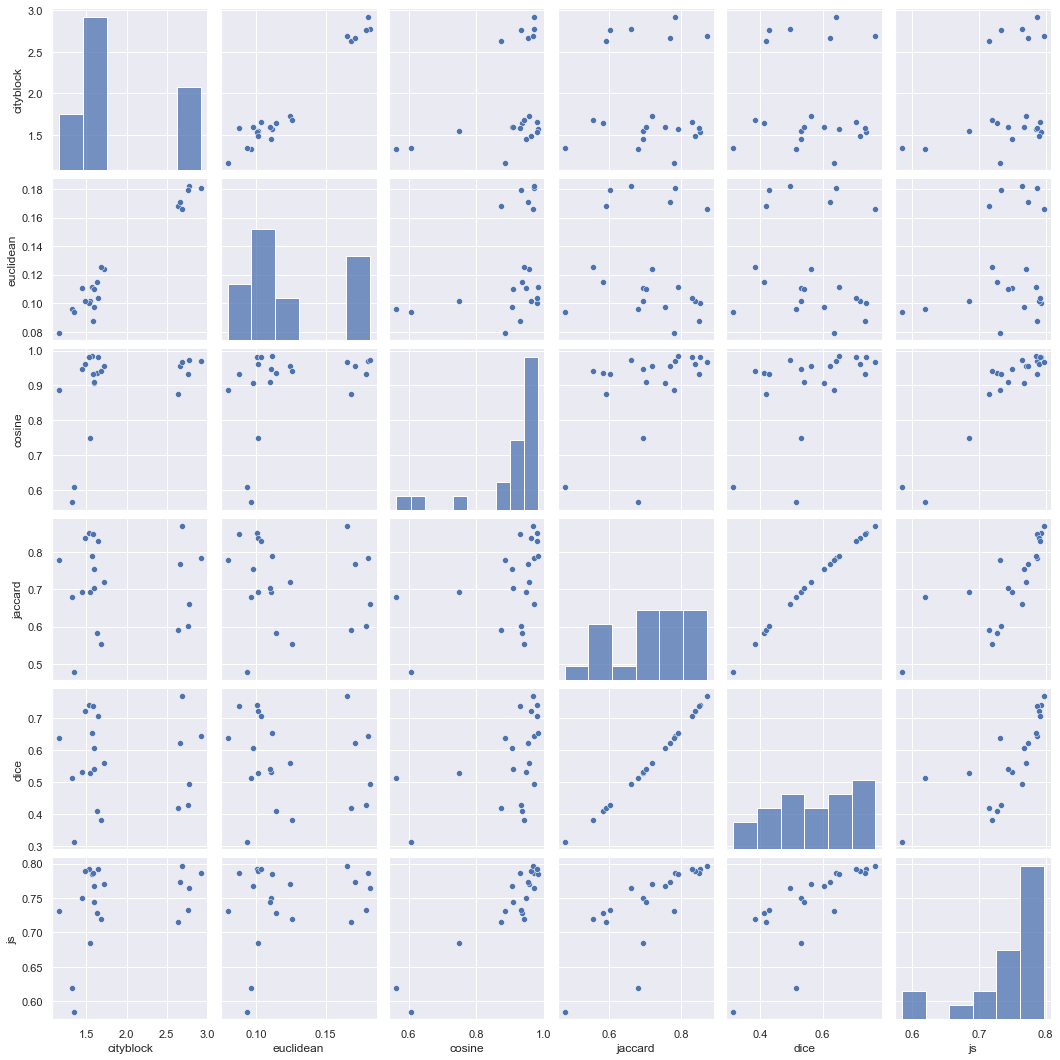

In [54]:
# compare distributions
SAMPLE = PAIRS.sample(1000) if PAIRS.shape[0] > 1000 else PAIRS
sns.pairplot(SAMPLE);

### Creating Dendrograms

In [55]:
title_list = [
    "Sorcerer's Stone","Chamber of Secrets","Prisoner of Azkaban","Goblet of Fire",
    "Order of the Phoenix","Half-Blood Prince","Deathly Hallows"]
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 4)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = title_list
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    

<Figure size 432x288 with 0 Axes>

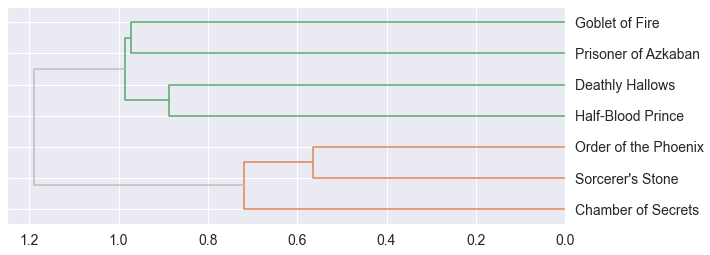

In [56]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=1)

<Figure size 432x288 with 0 Axes>

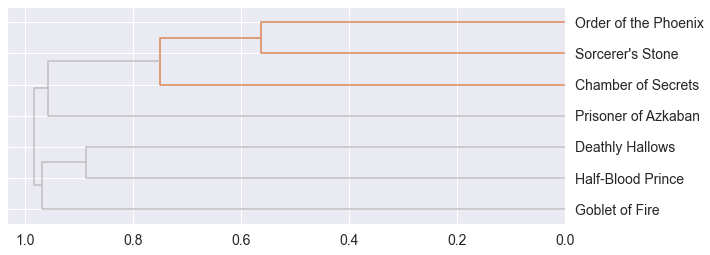

In [57]:
hca(PAIRS.cosine, linkage_method='complete', color_thresh=0.8);

<Figure size 432x288 with 0 Axes>

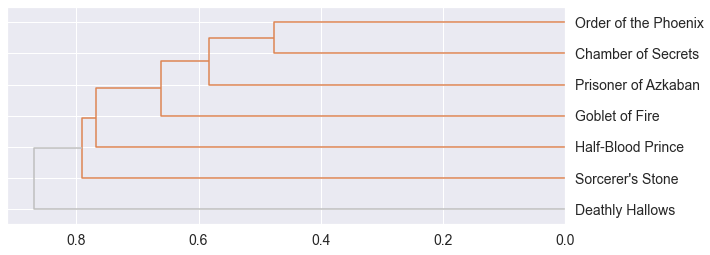

In [58]:
hca(PAIRS.jaccard, color_thresh=.8);

<Figure size 432x288 with 0 Axes>

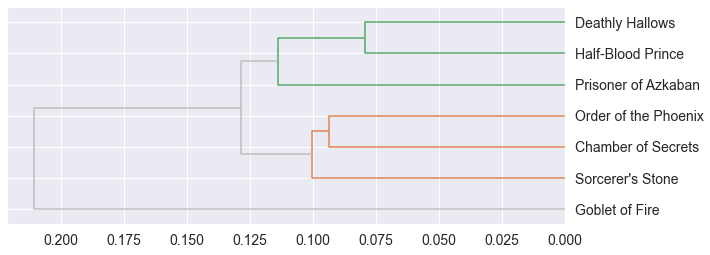

In [59]:
hca(PAIRS.euclidean, linkage_method='ward', color_thresh=0.12);

<Figure size 432x288 with 0 Axes>

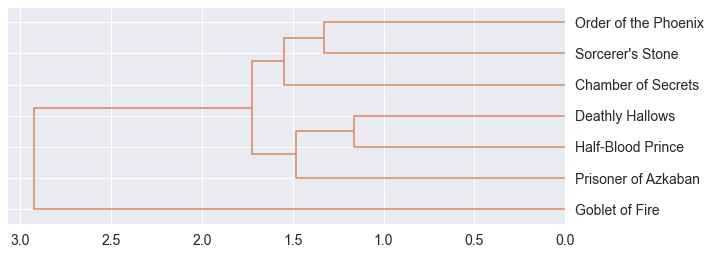

In [60]:
hca(PAIRS.cityblock, color_thresh=5);

<Figure size 432x288 with 0 Axes>

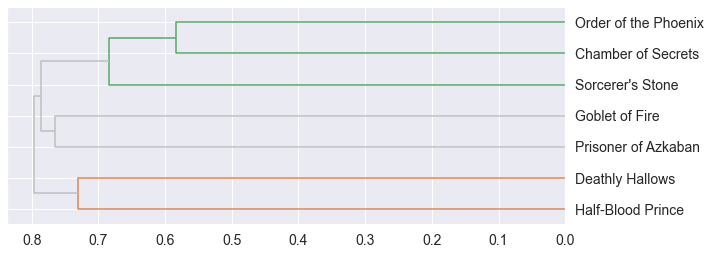

In [61]:
hca(PAIRS.js, color_thresh=.75);

# PCA

In [62]:
# normalize doc vector lengths
TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

In [63]:
# center term vectors
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()
TFIDF_L2 = TFIDF_L2.head(1000)

In [64]:
TFIDF_L2

term_str,slughorn,dont,lupin,umbridge,ng,ve,bagman,nd,harrys,luna,...,youngsters,idiots,react,banished,apothecary,hunt,triangular,startled,oil,protego
book_id,,,,,,,,,,,,,,,,,,,,,
Chamber of Secrets,-0.083006,0.198067,-0.114860,-0.090862,-0.047585,-0.084424,-0.070174,-0.039427,0.124853,-0.059819,...,0.006965,-0.002241,-0.002241,0.004484,-0.000822,0.005788,-0.002580,-0.002397,0.004460,-0.002334
Deathly Hallows,-0.057985,0.079943,-0.018336,-0.035480,-0.047585,-0.043103,-0.070174,-0.039427,0.013120,0.140170,...,-0.002957,0.000033,0.000033,-0.002227,-0.003038,-0.000374,0.013342,0.000402,0.001876,0.008434
Goblet of Fire,-0.083006,-0.123269,-0.110262,-0.090862,-0.047585,0.004928,0.417690,-0.039427,-0.044998,-0.059819,...,-0.002957,-0.002241,-0.002241,0.002115,-0.003038,-0.002207,-0.000440,-0.000817,-0.002189,-0.002334
Half-Blood Prince,0.473014,-0.121216,-0.090999,-0.079466,0.285508,-0.021374,-0.070174,0.236564,-0.056225,0.001303,...,-0.002957,-0.002241,-0.002241,-0.002227,-0.000985,-0.000561,-0.002580,-0.000135,-0.000136,-0.001298
Order of the Phoenix,-0.083006,0.213013,-0.044160,0.478394,-0.047585,-0.085645,-0.066821,-0.039427,0.094625,0.097803,...,-0.002957,0.011172,0.011172,0.002309,-0.003038,-0.001306,-0.002580,-0.000540,-0.002189,0.002202
Prisoner of Azkaban,-0.083006,-0.123269,0.493477,-0.090862,-0.047585,0.081858,-0.070174,-0.039427,-0.065687,-0.059819,...,-0.002957,-0.002241,-0.002241,-0.002227,-0.000483,0.000866,-0.002580,0.003233,0.000366,-0.002334
Sorcerer's Stone,-0.083006,-0.123269,-0.114860,-0.090862,-0.047585,0.147758,-0.070174,-0.039427,-0.065687,-0.059819,...,0.007820,-0.002241,-0.002241,-0.002227,0.011405,-0.002207,-0.002580,0.000255,-0.002189,-0.002334


In [65]:
# get COV matrix
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)
COV.head()

term_str,slughorn,dont,lupin,umbridge,ng,ve,bagman,nd,harrys,luna,...,youngsters,idiots,react,banished,apothecary,hunt,triangular,startled,oil,protego
term_str,,,,,,,,,,,,,,,,,,,,,
slughorn,0.043592,-0.010900,-0.008509,-0.007512,0.026260,-0.002160,-0.006796,0.021758,-0.005156,0.000705,...,-0.000286,-0.000208,-0.000208,-0.000216,-0.000104,-0.000054,-0.000183,-0.000011,-0.000005,-0.000085
dont,-0.010900,0.025212,-0.009279,0.020718,-0.006729,-0.010789,-0.009904,-0.005576,0.012415,0.007026,...,0.000106,0.000506,0.000506,0.000293,-0.000318,0.000224,0.000168,-0.000145,0.000180,0.000284
lupin,-0.008509,-0.009279,0.048772,-0.004532,-0.005052,0.006516,-0.008990,-0.004186,-0.005592,-0.002698,...,-0.000396,-0.000106,-0.000106,-0.000242,-0.000140,0.000062,-0.000088,0.000327,0.000039,-0.000082
umbridge,-0.007512,0.020718,-0.004532,0.044910,-0.004412,-0.008564,-0.007121,-0.003655,0.008992,0.010575,...,-0.000313,0.001056,0.001056,0.000194,-0.000318,-0.000128,-0.000127,-0.000048,-0.000191,0.000284
ng,0.026260,-0.006729,-0.005052,-0.004412,0.015850,-0.001187,-0.003896,0.013133,-0.003121,0.000072,...,-0.000164,-0.000124,-0.000124,-0.000124,-0.000055,-0.000031,-0.000143,-0.000008,-0.000008,-0.000072


### making eig stuff

In [66]:
# decompose matrix - TAKES FOREVER
eig_vals, eig_vecs = eigh(COV)

In [67]:
# convert eigen data into new dataframes
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'
EIG_VEC.iloc[:10, :10].style.background_gradient(cmap=colors)

term_str,slughorn,dont,lupin,umbridge,ng,ve,bagman,nd,harrys,luna
term_str,,,,,,,,,,
slughorn,0.002147,0.001094,-0.012922,0.000288,0.000321,-0.003721,-0.034995,0.076171,-0.100401,0.092080
dont,0.134699,0.090587,-0.543799,0.072333,0.092441,0.044014,-0.122074,0.174485,0.088173,-0.082909
lupin,-0.166157,0.045952,0.163748,-0.014085,-0.005104,-0.033167,-0.029847,0.042486,0.030728,-0.081008
umbridge,-0.040671,-0.083344,-0.178335,0.018771,0.085233,0.014268,0.009759,-0.290733,0.101060,-0.117398
ng,0.175629,0.014539,-0.411553,0.050410,0.083344,0.036818,-0.009916,0.108053,-0.001265,-0.035655
ve,0.600650,0.046746,0.031005,-0.001438,0.025583,0.161682,0.537781,-0.154187,0.064714,0.084520
bagman,0.565237,-0.042214,0.044282,-0.013993,-0.054665,-0.197682,-0.328188,-0.100211,0.029070,-0.083777
nd,0.043300,0.005921,-0.163900,-0.024629,-0.145393,0.012852,-0.113890,0.206104,-0.427584,0.154347
harrys,0.141790,0.204337,-0.004646,-0.043311,-0.184510,-0.065233,0.100611,0.159568,0.024894,-0.131323


In [68]:
#EIG_VEC.to_csv('eig_vec.csv')
#EIG_VAL.to_csv('eig_val.csv')
#np.savetxt('eig_vals.csv', eig_vals, delimiter=",")
#np.savetxt('eig_vecs.csv', eig_vecs, delimiter=",")

In [69]:
# exploring term pairs
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']
EIG_VEC_PAIRS.head(20)


,,covariance
term1,term2,
slughorn,youre,0.631565
ve,slughorn,0.600650
bagman,slughorn,0.565237
ve,bagman,0.537781
winky,dont,0.523937
lupin,triangular,0.486881
slughorn,oil,0.480736
im,dont,0.479643
weve,umbridge,0.478421


<AxesSubplot:xlabel='term1,term2'>

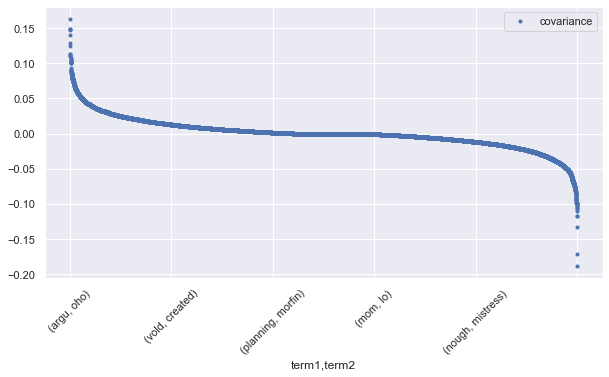

In [70]:
EIG_VEC_PAIRS.sample(10000).sort_values('covariance', ascending=False).plot(rot=45, style='.', figsize=(10, 5))


### Select Principle Components

In [71]:
# combine eig vals and vecs
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS.sort_values('eig_val', ascending=False).head(10)

,eig_val,slughorn,dont,lupin,umbridge,ng,ve,bagman,nd,harrys,...,youngsters,idiots,react,banished,apothecary,hunt,triangular,startled,oil,protego
term_str,,,,,,,,,,,,,,,,,,,,,
protego,2.171159e-01,-0.097107,0.333939,-0.136479,0.256725,-0.062198,-0.162383,-0.118274,-0.051535,0.163449,...,0.000098,0.006360,0.006360,0.003711,-0.005715,0.003000,0.003750,-0.002001,0.002728,0.004642
oil,1.638565e-01,0.480736,-0.060170,-0.171287,-0.038707,0.287182,-0.084126,0.001299,0.237951,-0.027219,...,-0.005443,-0.001091,-0.001091,-0.001284,-0.004861,-0.000584,0.000868,-0.000843,0.000310,0.001065
startled,1.627205e-01,-0.127932,-0.017345,-0.170713,-0.024052,-0.074915,-0.055142,0.434188,-0.062072,0.012113,...,-0.002913,-0.000618,-0.000618,0.004067,-0.005554,-0.001011,0.000072,-0.001756,-0.001267,-0.001593
triangular,1.482187e-01,-0.018074,-0.020027,0.486881,0.030346,-0.011084,-0.030725,-0.005749,-0.009184,-0.015160,...,-0.008696,0.000741,0.000741,-0.000672,-0.008281,0.001439,0.000247,0.002687,0.001178,0.000387
hunt,1.223475e-01,-0.087341,-0.037691,0.010634,0.041544,-0.066037,0.016909,0.037564,-0.054716,-0.060061,...,-0.006558,0.001919,0.001919,-0.004297,-0.001942,-0.004479,0.014733,0.001593,-0.001527,0.009593
apothecary,8.694443e-02,-0.019101,-0.037966,0.018100,-0.586553,-0.019000,0.004120,-0.019890,-0.015743,-0.002542,...,0.005734,-0.013316,-0.013316,-0.000393,0.000099,0.005628,0.007957,-0.000614,0.006730,0.000480
banished,2.217602e-16,0.001481,-0.111527,0.435232,0.162997,0.250534,0.184939,0.109511,0.270354,-0.380628,...,0.000070,0.001580,0.001677,0.003364,-0.001415,0.001959,0.004339,-0.001827,-0.001690,0.003360
react,2.153159e-16,-0.001110,-0.234270,-0.384605,0.204774,-0.142275,-0.228480,0.202798,0.040226,-0.088124,...,0.002302,0.000432,0.000466,0.000571,-0.000446,0.001134,0.001500,0.001329,-0.000076,-0.000873
idiots,1.768011e-16,-0.003054,-0.009325,-0.238297,-0.031119,-0.093778,0.164099,-0.205239,0.051041,-0.105380,...,-0.007567,-0.000899,-0.000861,-0.002255,-0.002588,0.001938,0.001563,0.000355,-0.001009,0.003303


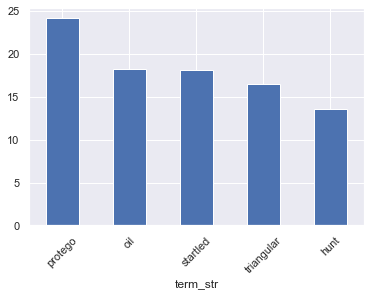

In [72]:
# compute and show explained Variance
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45);


### Get top 10 components

In [73]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'
COMPS


,eig_val,slughorn,dont,lupin,umbridge,ng,ve,bagman,nd,harrys,...,idiots,react,banished,apothecary,hunt,triangular,startled,oil,protego,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,2.171159e-01,-0.097107,0.333939,-0.136479,0.256725,-0.062198,-0.162383,-0.118274,-0.051535,0.163449,...,0.006360,0.006360,0.003711,-0.005715,0.003000,0.003750,-0.002001,0.002728,0.004642,24.09
PC1,1.638565e-01,0.480736,-0.060170,-0.171287,-0.038707,0.287182,-0.084126,0.001299,0.237951,-0.027219,...,-0.001091,-0.001091,-0.001284,-0.004861,-0.000584,0.000868,-0.000843,0.000310,0.001065,18.18
PC2,1.627205e-01,-0.127932,-0.017345,-0.170713,-0.024052,-0.074915,-0.055142,0.434188,-0.062072,0.012113,...,-0.000618,-0.000618,0.004067,-0.005554,-0.001011,0.000072,-0.001756,-0.001267,-0.001593,18.06
PC3,1.482187e-01,-0.018074,-0.020027,0.486881,0.030346,-0.011084,-0.030725,-0.005749,-0.009184,-0.015160,...,0.000741,0.000741,-0.000672,-0.008281,0.001439,0.000247,0.002687,0.001178,0.000387,16.45
PC4,1.223475e-01,-0.087341,-0.037691,0.010634,0.041544,-0.066037,0.016909,0.037564,-0.054716,-0.060061,...,0.001919,0.001919,-0.004297,-0.001942,-0.004479,0.014733,0.001593,-0.001527,0.009593,13.58
PC5,8.694443e-02,-0.019101,-0.037966,0.018100,-0.586553,-0.019000,0.004120,-0.019890,-0.015743,-0.002542,...,-0.013316,-0.013316,-0.000393,0.000099,0.005628,0.007957,-0.000614,0.006730,0.000480,9.65
PC6,1.132622e-21,0.000000,-0.000632,-0.000153,-0.000627,0.000109,0.000525,0.000081,-0.000901,0.000041,...,0.021864,-0.025960,0.018693,-0.006347,0.054990,0.021353,0.007695,-0.033427,0.006484,0.00
PC7,1.103771e-21,0.000000,0.002032,0.000042,0.000328,-0.003467,-0.000572,0.000427,-0.002138,-0.001188,...,0.010254,-0.000762,0.033040,0.046226,-0.006028,0.037580,-0.002662,-0.008117,-0.008594,0.00
PC8,1.114072e-21,0.000000,0.000257,-0.000490,-0.001222,-0.000131,0.000442,0.000202,-0.000120,0.001071,...,-0.020645,0.018818,0.009998,0.028339,-0.005029,-0.026492,-0.030387,-0.003098,-0.024140,0.00


In [74]:
# projected components onto vocabulary
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'
LOADINGS.head(10).style.background_gradient(cmap=colors)

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
slughorn,-0.097107,0.480736,-0.127932,-0.018074,-0.087341,-0.019101,0.000000,0.000000,0.000000,0.000000
dont,0.333939,-0.060170,-0.017345,-0.020027,-0.037691,-0.037966,-0.000632,0.002032,0.000257,0.000334
lupin,-0.136479,-0.171287,-0.170713,0.486881,0.010634,0.018100,-0.000153,0.000042,-0.000490,0.000203
umbridge,0.256725,-0.038707,-0.024052,0.030346,0.041544,-0.586553,-0.000627,0.000328,-0.001222,0.000030
ng,-0.062198,0.287182,-0.074915,-0.011084,-0.066037,-0.019000,0.000109,-0.003467,-0.000131,0.000130
ve,-0.162383,-0.084126,-0.055142,-0.030725,0.016909,0.004120,0.000525,-0.000572,0.000442,-0.000280
bagman,-0.118274,0.001299,0.434188,-0.005749,0.037564,-0.019890,0.000081,0.000427,0.000202,-0.000092
nd,-0.051535,0.237951,-0.062072,-0.009184,-0.054716,-0.015743,-0.000901,-0.002138,-0.000120,-0.000753
harrys,0.163449,-0.027219,0.012113,-0.015160,-0.060061,-0.002542,0.000041,-0.001188,0.001071,0.000262


In [75]:
top_terms = []
for i in range(10):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})
COMP_GLOSS


1,pos,neg
comp_id,,
PC0,dont umbridge lockhart youre harrys thats ive ...,quirrell ve lupin bagman pettigrew flamel slug...
PC1,slughorn ng nd th wa mclaggen rry morfin ed sa,quirrell lupin pettigrew flamel marge ve mom s...
PC2,bagman winky champions ludo karkaroff moody kr...,lupin quirrell slughorn pettigrew flamel ng ma...
PC3,lupin pettigrew marge dementors crookshanks er...,quirrell flamel mom piers turban nicolas ronan...
PC4,xenophilius griphook hallows horcrux luna krea...,lockhart lockharts gilderoy myrtle wasnt dobby...
PC5,lockhart xenophilius griphook lockharts hallow...,umbridge towards umbridges sirius forwards pro...
PC6,members lime oliver conscious bedside weather ...,fellow momentarily tones dabbing weasle ort te...
PC7,candy fidelius pro frying zey crumple sorcerer...,podmore ted inquisitorial cliff ship magazine ...
PC8,murderer fountain lack steak flask telescopes ...,stunning graveyard memories chickens befo wink...


### Project Docs onto components

## also making LIB

In [76]:
lib_stuff = {'book_id':title_list,
             'source_file_path':['hp1.txt','hp2.txt','hp3.txt','hp4.txt','hp5.txt','hp6.txt','hp7.txt'],
             'author':['JK Rowling','JK Rowling','JK Rowling','JK Rowling','JK Rowling','JK Rowling','JK Rowling'],
             'title':title_list,
             'n_tokens':[len(TOKENS1),len(TOKENS2),len(TOKENS3),len(TOKENS4),len(TOKENS5),len(TOKENS6),len(TOKENS7)],
             'n_chapters':[len(CHAPS1),len(CHAPS2),len(CHAPS3),len(CHAPS4),len(CHAPS5),len(CHAPS6),len(CHAPS7)],
             'n_sentences':[len(SENTS1),len(SENTS2),len(SENTS3),len(SENTS4),len(SENTS5),len(SENTS6),len(SENTS7)],
             'label':['hp1','hp2','hp3','hp4','hp5','hp6','hp7'],
             'genre':['nonfiction','nonfiction','nonfiction','nonfiction','nonfiction','nonfiction','nonfiction']}
LIB = pd.DataFrame(lib_stuff)
                      

In [77]:
LIB_COLS = ['author','title', 'n_chapters', 'genre']

In [78]:
DCM = TFIDF_L2.dot(COMPS[COV.index].T)
#DCM = DCM.join(LIB, on='book_id')
LIB = LIB.set_index('book_id')
DCM = pd.concat([DCM, LIB], axis=1, join='inner')
DCM['doc'] = DCM.apply(lambda x: f"{x.label} {str(x.name[1]).zfill(2)}", 1)

### Downlaod LIB to csv

In [79]:
LIB

,source_file_path,author,title,n_tokens,n_chapters,n_sentences,label,genre
book_id,,,,,,,,
Sorcerer's Stone,hp1.txt,JK Rowling,Sorcerer's Stone,79970,17,8100,hp1,nonfiction
Chamber of Secrets,hp2.txt,JK Rowling,Chamber of Secrets,89647,18,7330,hp2,nonfiction
Prisoner of Azkaban,hp3.txt,JK Rowling,Prisoner of Azkaban,107506,22,11683,hp3,nonfiction
Goblet of Fire,hp4.txt,JK Rowling,Goblet of Fire,198594,37,20095,hp4,nonfiction
Order of the Phoenix,hp5.txt,JK Rowling,Order of the Phoenix,263251,38,25729,hp5,nonfiction
Half-Blood Prince,hp6.txt,JK Rowling,Half-Blood Prince,185082,30,16815,hp6,nonfiction
Deathly Hallows,hp7.txt,JK Rowling,Deathly Hallows,203899,37,19841,hp7,nonfiction


In [243]:
# download LIB to csv

# LIB.to_csv('LIB_hp.csv', index=True)

### Visualize PCA 

In [81]:
def vis_pcs(M, a, b, label='author', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()
    
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)


In [82]:
vis_pcs(DCM, 0, 1, label='title')

In [83]:
vis_pcs(DCM, 1, 2, label='title')

In [84]:
vis_pcs(DCM, 2, 3, label='title')

In [85]:
# ... etc.

### Dendrograms

In [86]:
class HAC:
    """
    Takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. 
    The number of observations should be sufficiently 
    small to allow being plotted.
    Attributes:
        w (int): The width of the figure in inches.
        label_size (int): The font size of the labels in points.
        orientation (str): The orientation of the figure; 'top', 'bottom', 'left', 'right'. Defaults to 'left'.
        dist_measure (str): The distance measure to use; braycurtis, canberra, chebyshev, cityblock, correlation, 
            cosine, dice, euclidean, hamming, jaccard, jensenshannon, kulsinski, kulczynski1, mahalanobis, matching, 
            minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule. 
            Defaults to euclidean.
        linkage_method (str): The linkage method to use; single, complete, average, weighted, centroid, median, ward
            Defaults to ward.
        norm_type (str): The vector normalization type; l1, l2, max. Defaults to l2.
        color_thresh (float): The threshhold at which to apply coloring in the dendropgram. Defaults to None.
    """

    w:int = 10
    label_size:int = 14
    orientation:str = 'left'
    dist_metric:str = 'cosine' 
    linkage_method:str = 'ward' 
    norm_type:str = 'l2' 
    color_thresh:float = None
    
    def __init__(self, X, labels=None):
        self.X = X
        self.h = X.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = X.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.X, norm=self.norm_type), metric=self.dist_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.linkage_method)        
        
    def plot_tree(self):
        if not self.color_thresh:
            self.color_thresh = df(self.TREE)[2].median()
        plt.figure()
        plt.subplots(figsize=(self.w, self.h / 3))
        sch.dendrogram(self.TREE, 
            labels=self.labels, 
            orientation=self.orientation,
            count_sort=True,
            distance_sort=True,
            above_threshold_color='.75',
            color_threshold=self.color_thresh);
        plt.tick_params(axis='both', which='major', labelsize=self.label_size)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

In [87]:
X = DCM[COMPS.index].groupby('book_id').mean()
titles = LIB.loc[list(X.index)].apply(lambda x: x.title + ' ', 1)
X.index = titles

In [88]:
X.style.background_gradient(cmap=colors)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Chamber of Secrets,0.549845,-0.130009,0.046890,-0.113559,-0.500657,0.360889,-0.000000,-0.000000,0.000000,0.000000
Deathly Hallows,0.349767,0.053184,-0.112359,0.015251,0.671655,0.263035,-0.000000,-0.000000,0.000000,0.000000
Goblet of Fire,-0.319653,0.003229,0.869084,-0.010799,0.056582,-0.017402,0.000000,-0.000000,-0.000000,-0.000000
Half-Blood Prince,-0.243250,0.847631,-0.219582,-0.029594,-0.145535,-0.029757,-0.000000,0.000000,-0.000000,-0.000000
Order of the Phoenix,0.558336,-0.088992,-0.025925,0.046516,-0.008858,-0.562512,0.000000,0.000000,-0.000000,-0.000000
Prisoner of Azkaban,-0.400686,-0.308186,-0.251093,0.705175,-0.087428,0.040458,0.000000,0.000000,-0.000000,0.000000
Sorcerer's Stone,-0.494360,-0.376857,-0.307014,-0.612989,0.014240,-0.054712,-0.000000,0.000000,0.000000,-0.000000


<Figure size 432x288 with 0 Axes>

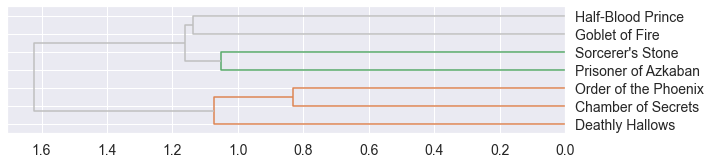

In [89]:
HAC(X).plot();

### Future - try to get VOCAB TFIDF and DFIDF cols ?

In [90]:
#VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'VB', 'JJ'])].sort_values('p', ascending=False).head(1000)
#XV = LOADINGS.loc[VSHORT.sort_values('p', ascending=False).head(100).index]
#HAC(XV).plot()

# Comparing to Sci-Kit Learn

In [91]:
pca_engine = PCA(n_components=7)

In [92]:
DCM_sk = pd.DataFrame(pca_engine.fit_transform(TFIDF_L2), index=TFIDF_L2.index)
DCM_sk.columns = ['PC{}'.format(i) for i in DCM_sk.columns]
DCM_sk = DCM_sk.join(LIB[LIB_COLS], on='book_id')
DCM_sk['doc'] = DCM_sk.apply(lambda x: "{}-{}-{}".format(x.author, x.title, x.name[1]), 1)

In [93]:
DCM_sk.iloc[:10, :10].style.background_gradient(cmap=colors)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,author,title,n_chapters
book_id,,,,,,,,,,
Chamber of Secrets,0.549845,-0.130009,0.046890,-0.113559,-0.500657,-0.360889,0.000000,JK Rowling,Chamber of Secrets,18
Deathly Hallows,0.349767,0.053184,-0.112359,0.015251,0.671655,-0.263035,0.000000,JK Rowling,Deathly Hallows,37
Goblet of Fire,-0.319653,0.003229,0.869084,-0.010799,0.056582,0.017402,0.000000,JK Rowling,Goblet of Fire,37
Half-Blood Prince,-0.243250,0.847631,-0.219582,-0.029594,-0.145535,0.029757,0.000000,JK Rowling,Half-Blood Prince,30
Order of the Phoenix,0.558336,-0.088992,-0.025925,0.046516,-0.008858,0.562512,0.000000,JK Rowling,Order of the Phoenix,38
Prisoner of Azkaban,-0.400686,-0.308186,-0.251093,0.705175,-0.087428,-0.040458,0.000000,JK Rowling,Prisoner of Azkaban,22
Sorcerer's Stone,-0.494360,-0.376857,-0.307014,-0.612989,0.014240,0.054712,0.000000,JK Rowling,Sorcerer's Stone,17


In [94]:
vis_pcs(DCM_sk, 0, 1)

In [95]:
vis_pcs(DCM_sk, 1, 2)

In [96]:
vis_pcs(DCM_sk, 2, 3)

# Loadings

In [97]:
LOADINGS_sk = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS_sk.columns = ["PC{}".format(i) for i in LOADINGS_sk.columns]

In [98]:
LOADINGS_sk.index = TFIDF_L2.columns
LOADINGS_sk.index.name = 'term_str'

In [99]:
LOADINGS.sort_values('PC0').head(10)

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
quirrell,-0.188513,-0.190440,-0.158125,-0.344975,0.010190,-0.056155,0.000699,0.000957,-0.001192,-0.000048
ve,-0.162383,-0.084126,-0.055142,-0.030725,0.016909,0.004120,0.000525,-0.000572,0.000442,-0.000280
lupin,-0.136479,-0.171287,-0.170713,0.486881,0.010634,0.018100,-0.000153,0.000042,-0.000490,0.000203
bagman,-0.118274,0.001299,0.434188,-0.005749,0.037564,-0.019890,0.000081,0.000427,0.000202,-0.000092
pettigrew,-0.112863,-0.116221,-0.099736,0.300806,-0.031486,0.037041,-0.000754,0.000241,-0.000317,0.000366
flamel,-0.105117,-0.107166,-0.088639,-0.193069,0.009598,-0.027095,0.000178,0.009351,-0.002164,0.001005
slughorn,-0.097107,0.480736,-0.127932,-0.018074,-0.087341,-0.019101,0.000000,0.000000,0.000000,0.000000
marge,-0.083765,-0.087037,-0.071245,0.159104,-0.026978,0.010511,-0.000330,0.007067,-0.002755,0.000316
winky,-0.079033,0.000489,0.296959,-0.003703,0.025648,-0.018366,0.000309,0.000578,-0.000324,-0.000047


In [100]:
top_terms_sk= {}
for i in [0, 1]:
    for j in [0, 1]:
        top_terms_sk[f"{i}_{j}"] = ' '.join(LOADINGS_sk.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
    

In [101]:
top_terms_sk

{'0_0': 'dont umbridge lockhart youre harrys thats ive im wasnt weve',
 '0_1': 'quirrell ve lupin bagman pettigrew flamel slughorn marge winky mom',
 '1_0': 'slughorn ng nd th wa mclaggen rry morfin ed sa',
 '1_1': 'quirrell lupin pettigrew flamel marge ve mom scabbers piers flint'}

# LDA

In [102]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
# n_topics = 20
max_iter = 20
n_top_terms = 9

In [103]:
# bag is chapter
BAG = OHCO[:2]

In [104]:
CORPUS_ni = CORPUS.reset_index()
#CORPUS_ni = CORPUS_ni.dropna(subset=['pos'])
CORPUS_ni['pos'] = CORPUS_ni['pos'].str[0].astype(str)
DOCS = CORPUS_ni[CORPUS_ni.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [105]:
DOCS.head()

doc_str
book_id            chap_num                                                   
Chamber of Secrets 1         time argument broken breakfast number privet d...
                   2         shout thing creature bed bat ears eyes size te...
                   3         window talk bars ron mouth impact hit ron wind...
                   4         life burrow life privet drive dursleys everyth...
                   5         end summer vacation hogwarts month burrow happ...

### Create Vector Space

In [106]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [107]:
VOCAB2 = pd.DataFrame(index=TERMS)
VOCAB2.index.name = 'term_str'

In [108]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [109]:
VOCAB2['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [110]:
DOCS.term_count.describe()

count     199.000000
mean     1441.532663
std       380.401446
min       435.000000
25%      1163.000000
50%      1442.000000
75%      1698.500000
max      2254.000000
Name: term_count, dtype: float64

### Generate Model

In [111]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [112]:
# topic names
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

### Theta

In [113]:
lda_model = lda_engine.fit_transform(count_model)

In [114]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [115]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

### Phi

In [116]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [117]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
shield,0.025000,0.025000,0.025000,0.025000,0.025000,6.878581,0.025000,0.025000,2.709707,0.025000,0.025000,0.025000,4.615540,13.510512,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.052460,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.420949,7.987251,0.025000
telescope,4.213444,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,5.061535,0.025000,1.256644,0.025000,1.927389,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,5.665988,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
spots,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.472207,0.025000,0.025000,0.025000,2.049428,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.019069,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,7.076043,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,5.508253,0.025000,0.025000
box,0.027676,0.025000,2.274661,0.025000,0.025000,4.743402,0.025000,0.025000,0.025000,1.279363,2.071145,0.025000,12.629853,0.025000,10.345874,0.025000,0.025000,0.025000,28.042972,26.602860,0.025000,7.993225,8.784068,0.025000,0.025000,8.835002,3.529695,0.025000,19.190205,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
beating,0.025000,0.025000,3.914141,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.290994,0.025017,1.367550,3.813453,0.025000,3.690254,0.025000,0.025000,0.025000,5.013538,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,20.085052,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
team,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.074732,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,176.925487,12.539570,50.929620,0.025000,4.100307,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.580284
broken,14.269207,0.025000,10.653158,0.025000,0.025000,0.025000,0.025000,1.162239,0.025000,2.810212,0.025000,1.288675,2.974921,29.956005,8.180064,0.025000,0.025000,0.025000,8.203468,0.025000,0.025000,0.025000,0.025000,7.793425,8.179804,0.025000,5.079826,0.025000,39.203098,0.025000,0.025000,0.025000,0.025000,3.332282,3.108393,0.025000,0.025000,19.927998,7.302225,0.025000
gain,0.025000,0.025000,0.025000,0.025000,0.025000,3.710312,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.755543,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.186152,0.025000,0.025000,0.025000,4.618292,0.025000,0.025000,0.025000,0.621713,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.257989,0.025000,0.025000
confidence,3.272284,0.025000,1.902848,1.518255,0.025000,0.025000,0.025000,0.025000,4.065533,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.352424,0.025000,6.451356,0.025000,1.334498,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.302801,0.025000,0.025000,0.025000


### Create topics, get terms per topic

In [118]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
TOPICS.head()

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T00,dumbledore,snape,mcgonagall,voldemort,think,eyes,room,hogwarts,school
T01,aback,pro,presents,press,pressure,pretend,prevent,price,pride
T02,uncle,vernon,uncle vernon,dudley,aunt,petunia,aunt petunia,dursleys,house
T03,dumbledore,mrs,mr,dementors,voice,malfoy,witch,lucius,mr malfoy
T04,dumbledore,water,rock,lake,potion,surface,goblet,light,boat


In [119]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
TOPICS.label.values

array(['T00 dumbledore, snape, mcgonagall, voldemort, think, eyes, room, hogwarts, school',
       'T01 aback, pro, presents, press, pressure, pretend, prevent, price, pride',
       'T02 uncle, vernon, uncle vernon, dudley, aunt, petunia, aunt petunia, dursleys, house',
       'T03 dumbledore, mrs, mr, dementors, voice, malfoy, witch, lucius, mr malfoy',
       'T04 dumbledore, water, rock, lake, potion, surface, goblet, light, boat',
       'T05 voldemort, horcrux, dumbledore, horcruxes, tent, locket, sword, knew, slughorn',
       'T06 umbridge, dumbledore, fudge, firenze, centaurs, centaur, head, floor, face',
       'T07 voldemort, wand, death, cedric, eaters, death eaters, light, voldemort wand, hand',
       'T08 ron, hall, dumbledore, students, table, hermione, mcgonagall, gryffindor, hat',
       'T09 dobby, sir, potter, elf, sir dobby, bed, head, room, dobby dobby',
       'T10 yeh, ter, don, fer, yer, em, didn, ll, bit',
       'T11 mr, ron, hermione, diggory, mr diggory, wa

In [120]:
# set topics by Doc weight
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.head()

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,dumbledore,snape,mcgonagall,voldemort,think,eyes,room,hogwarts,school,"T00 dumbledore, snape, mcgonagall, voldemort, ...",9.544430,0.049369
T01,aback,pro,presents,press,pressure,pretend,prevent,price,pride,"T01 aback, pro, presents, press, pressure, pre...",0.003764,0.000344
T02,uncle,vernon,uncle vernon,dudley,aunt,petunia,aunt petunia,dursleys,house,"T02 uncle, vernon, uncle vernon, dudley, aunt,...",10.672525,0.042316
T03,dumbledore,mrs,mr,dementors,voice,malfoy,witch,lucius,mr malfoy,"T03 dumbledore, mrs, mr, dementors, voice, mal...",2.290607,0.010064
T04,dumbledore,water,rock,lake,potion,surface,goblet,light,boat,"T04 dumbledore, water, rock, lake, potion, sur...",1.024127,0.005648


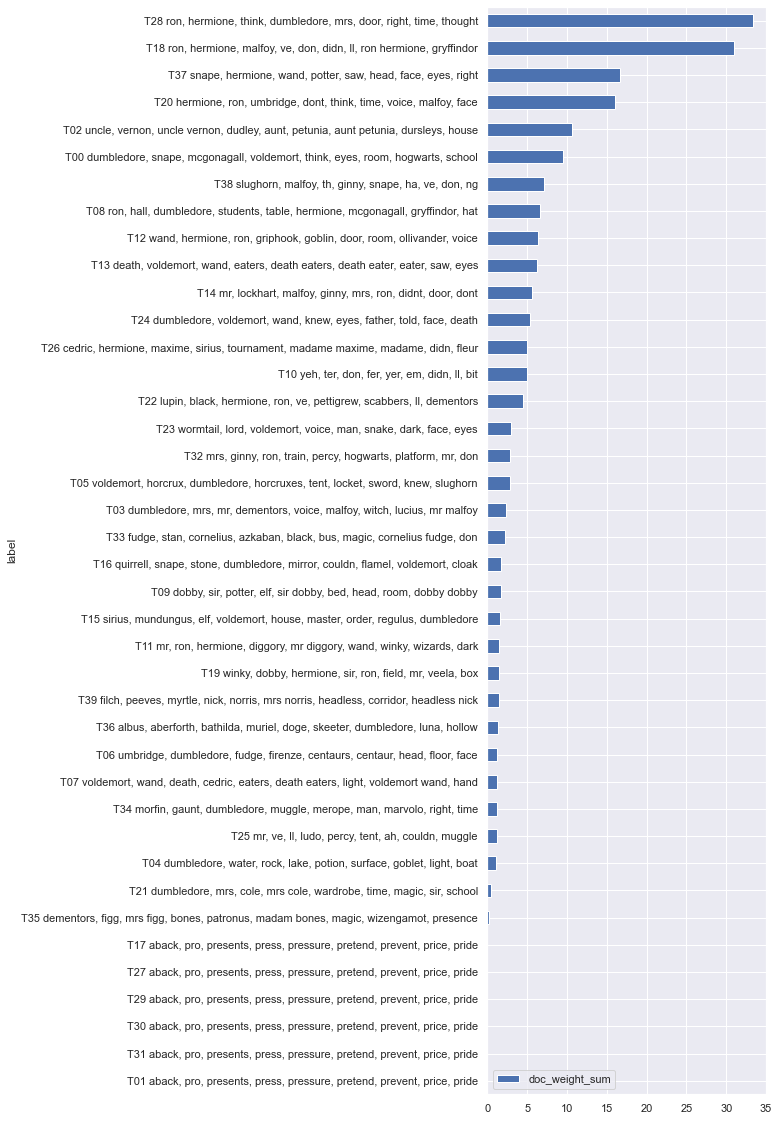

In [121]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));


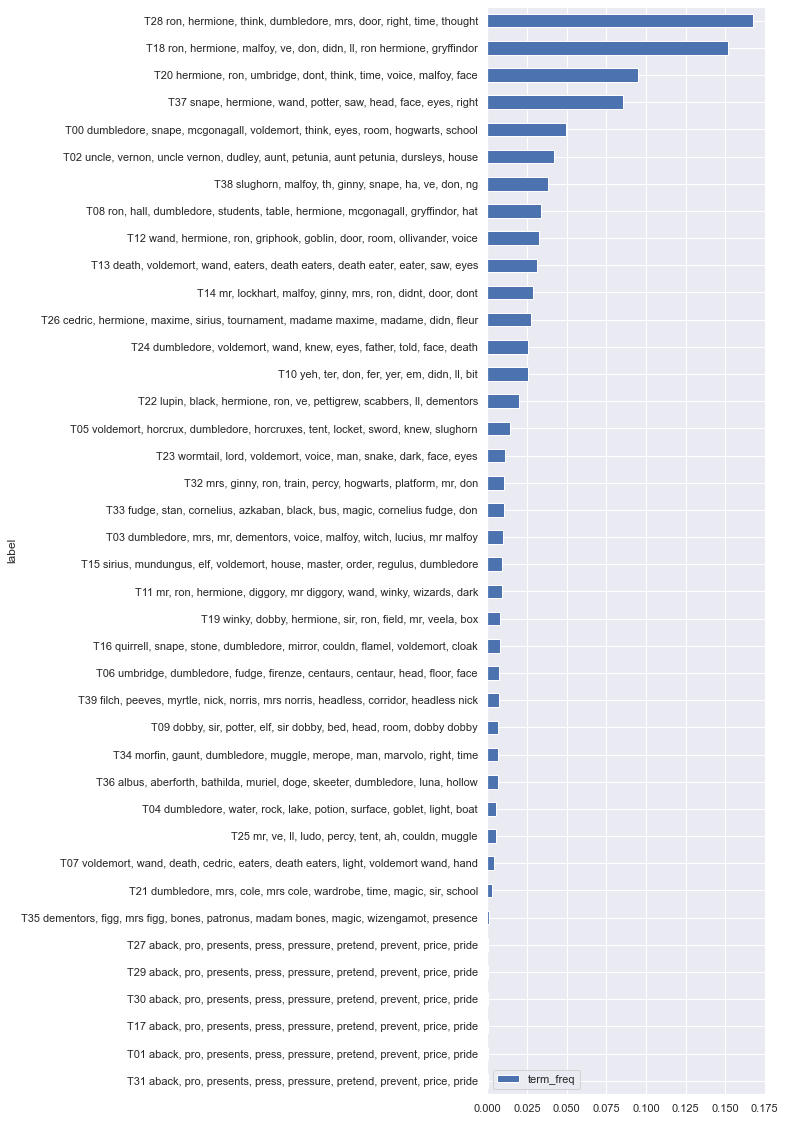

In [122]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


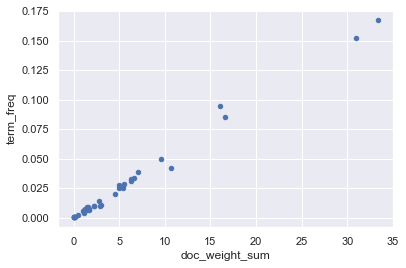

In [123]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

# Word Embeddings

In [124]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50,
    workers = 4
)

In [125]:
DOCS1 = CORPUS_ni[CORPUS_ni.pos.str.match(r'^NNS?$')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS1 = [doc for doc in DOCS1 if len(doc) > 1]

In [126]:
model = word2vec.Word2Vec(DOCS1, **w2v_params)

In [127]:
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.key_to_index.keys()], 
        term_str = model.wv.key_to_index.keys()
    )).set_index('term_str')

In [128]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(coords.vector.to_list())

In [129]:
coords['x'] = tsne_model[:,0]
coords['y'] = tsne_model[:,1]

In [130]:
if coords.shape[1] == 3:
    coords = coords.merge(VOCAB.reset_index(), on='term_str')
    coords = coords.set_index('term_str')

In [135]:
coords = coords.merge(vocab[['max_pos']], left_index=True, right_index=True, how='left')
coords['pos_max'] = coords.apply(lambda x: x['max_pos'] if x.name in vocab.index else None, axis=1)
coords.drop('max_pos', axis=1, inplace=True)

In [136]:
#coords = coords[coords.stop == 0]

In [137]:
coords = coords.join(vocab['tfidf'], on='term_str')
#coords['tfidf'] = (coords['tfidf'] - coords['tfidf'].min()) / (coords['tfidf'].max() - coords['tfidf'].min())

ValueError: columns overlap but no suffix specified: Index(['tfidf'], dtype='object')

In [138]:
px.scatter(coords.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           #size='tfidf_max',
           size='tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [221]:
coords.columns

Index(['vector', 'x', 'y', 'n', 'n_chars', 'p', 'i', 'n_pos', 'max_pos_x',
       'stop', 'stem_porter', 'stem_snowball', 'stem_lancaster', 'max_pos_y',
       'tfidf', 'pos_max'],
      dtype='object')

In [222]:
VOCAB3.columns

Index(['n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x',
       'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x',
       'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp',
       'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y',
       'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2',
       'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'],
      dtype='object')

In [223]:
vocab.columns

Index(['n', 'n_chars', 'p', 'i', 'n_pos', 'max_pos', 'stop', 'stem_porter',
       'stem_snowball', 'stem_lancaster', 'p2', 'h', 'tf', 'num_books',
       'num_chaps', 'num_sents', 'idf', 'tfidf'],
      dtype='object')

In [224]:
# vocab.to_csv('vocab_hp.csv', index=False)

### Analogies

In [139]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [140]:
complete_analogy('man', 'boy', 'woman', 3)

,term,sim
0,not,0.956075
1,ill,0.953545
2,present,0.950454


In [141]:
complete_analogy('day', 'night', 'sun', 5)

,term,sim
0,darkness,0.975772
1,lay,0.960338
2,glass,0.955982
3,light,0.952764
4,flames,0.951930


In [142]:
get_most_similar('man')

,term,sim
0,snake,0.922709
1,pain,0.888922
2,body,0.869911
3,witch,0.863058
4,wormtail,0.861417
5,forehead,0.847668
6,scar,0.842381
7,felt,0.841995
8,broken,0.826144
9,cold,0.825736


In [143]:
get_most_similar(['man','woman'],['boy','girl'])

,term,sim
0,light,0.829454
1,air,0.780483
2,floor,0.779883
3,ground,0.759817
4,flew,0.736757
5,body,0.727811
6,darkness,0.718939
7,burst,0.716101
8,thin,0.710926
9,beneath,0.709527


In [144]:
coords

,vector,x,y,n,n_chars,p,i,n_pos,max_pos_x,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_y,tfidf,pos_max
term_str,,,,,,,,,,,,,,,,
s,"[-0.11298585, 0.0065220254, 0.08439004, -0.182...",34.372070,-6.260707,8128,1,0.007346,7.088825,3,NN,1,s,s,s,NN,0.051422,NN
ron,"[0.2947893, 0.12605256, 0.17766315, -0.6940048...",-1.357736,-25.207333,6017,3,0.005438,7.522681,5,NN,0,ron,ron,ron,NN,0.038067,NN
hermione,"[0.19096102, 0.12453712, 0.112152696, -0.55245...",-1.184428,-24.997581,5051,8,0.004565,7.775156,4,NN,0,hermion,hermion,herm,NN,0.031955,NN
t,"[-0.49767983, 0.2060233, 0.9944709, -0.2582947...",47.656403,0.831097,4876,1,0.004407,7.826027,5,NN,1,t,t,t,NN,0.030848,NN
dumbledore,"[-0.59499985, -0.30767766, -0.08050824, 0.1975...",32.613766,17.267717,3041,10,0.002748,8.507179,2,NN,0,dumbledor,dumbledor,dumbl,NN,0.019239,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seventeen,"[-0.15572235, -0.023258863, -0.05557381, 0.019...",14.842168,7.911807,50,9,0.000045,14.433653,1,NN,0,seventeen,seventeen,seventeen,NN,0.000271,NN
pretend,"[-0.17037842, -0.0042274357, -0.061342422, -0....",9.256346,1.135684,51,7,0.000046,14.405084,2,NN,0,pretend,pretend,pretend,NN,0.000323,NN
rise,"[-0.19570759, -0.0054873554, -0.13003674, 0.12...",-15.212090,12.312825,50,4,0.000045,14.433653,1,NN,0,rise,rise,ris,NN,0.000271,NN


### Looking with HAC

In [145]:
proper_nouns = 'tommy emily tuppence agnes edmund holmes'.split()
#coords2 = coords.loc[~coords.index.isin(proper_nouns), ['vector','stop','tfidf_sum','pos_max']]
coords2 = coords.loc[~coords.index.isin(proper_nouns), ['vector','x','y','doc_count']]

KeyError: "['doc_count'] not in index"

In [146]:
coords2

NameError: name 'coords2' is not defined

In [147]:
def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, term_pos_pat = r'^(N|V)', color_thresh=1):
    term_filter = coords.pos_max.str.match(term_pos_pat) & (coords.stop == 0) & (coords.index.str.len() > 2)
    M = coords[term_filter].sort_values('tfidf_sum', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

plot_terms_tree(coords2, term_pos_pat=r'^NN[^P]?', color_thresh=9, terms_n=75)

plot_terms_tree(coords2, term_pos_pat=r'^V', color_thresh=8, terms_n=75)

# Sentiment Analysis

In [148]:
nrc_file = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [149]:
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

In [150]:
nrc.sum().sort_values(ascending=False)

nrc_negative        2366
nrc_fear            1368
nrc_positive        1281
nrc_anger           1208
nrc_sadness         1137
nrc_disgust         1004
nrc_trust            935
nrc_joy              686
nrc_anticipation     682
nrc_surprise         454
dtype: int64

In [151]:
nrc['nrc_sentiment'] = nrc.nrc_positive - nrc.nrc_negative

In [152]:
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust nrc_sentiment"
emo = 'sentiment'

In [153]:
salex = nrc.copy()
salex.columns = [col.replace('nrc_','') for col in salex.columns]

In [154]:
salex

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [155]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [156]:
TOKENS = CORPUS.copy()

In [157]:
TOKENS = TOKENS.join(salex, on='term_str', how='left')
TOKENS[emo_cols] = TOKENS[emo_cols].fillna(0)

In [158]:
TOKENS[salex.columns].sample(2)

,,,,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
book_id,chap_num,sent_num,token_num,,,,,,,,,,,
Order of the Phoenix,18,272,7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
Chamber of Secrets,6,339,3,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [159]:
TOKENS[['term_str'] + emo_cols].sample(2)

,,,,term_str,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
book_id,chap_num,sent_num,token_num,,,,,,,,,,
Goblet of Fire,35,780,6,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Prisoner of Azkaban,22,498,4,quidditch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
TOKENS[emo_cols] = TOKENS[emo_cols].fillna(0)

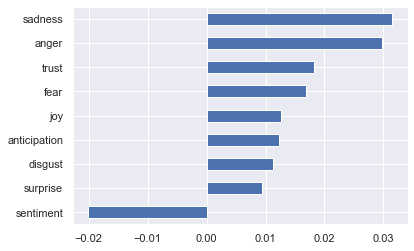

In [161]:
TOKENS[emo_cols].mean().sort_values().plot.barh();

### sentiment by chapter

In [162]:
TOKENS_chaps = TOKENS.groupby(CHAPS)[emo_cols].mean()

In [163]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

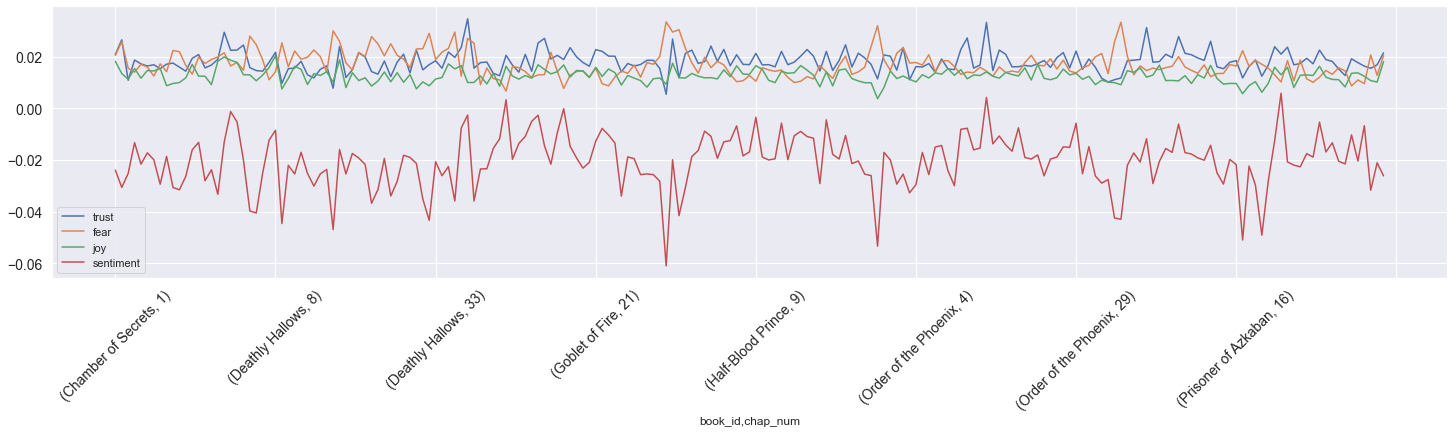

In [164]:
plot_sentiments(TOKENS_chaps, ['trust','fear','joy','sentiment'])

### Using Vader

In [165]:
analyser = SentimentIntensityAnalyzer()

In [166]:
# takes awhile
TOKENS_sents = TOKENS.groupby(SENTS)[emo_cols].mean()
TOKENS_sents['sent_str'] = TOKENS.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
TOKENS_vader_cols = TOKENS_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
TOKENS_vader = pd.concat([TOKENS_sents, TOKENS_vader_cols], axis=1)


<AxesSubplot:xlabel='book_id,chap_num,sent_num'>

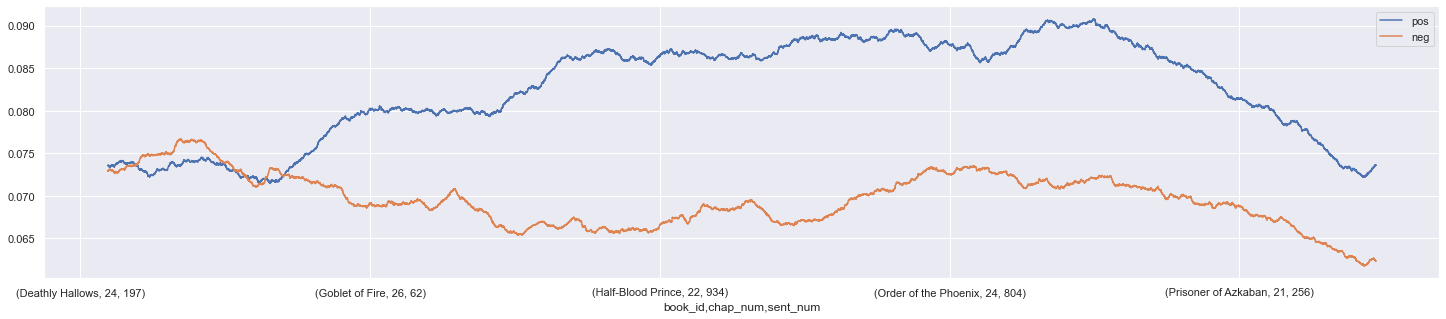

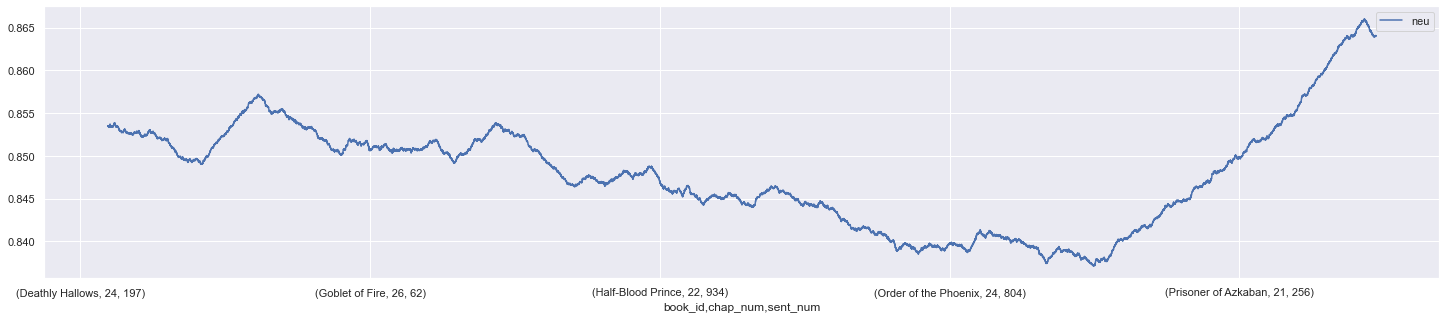

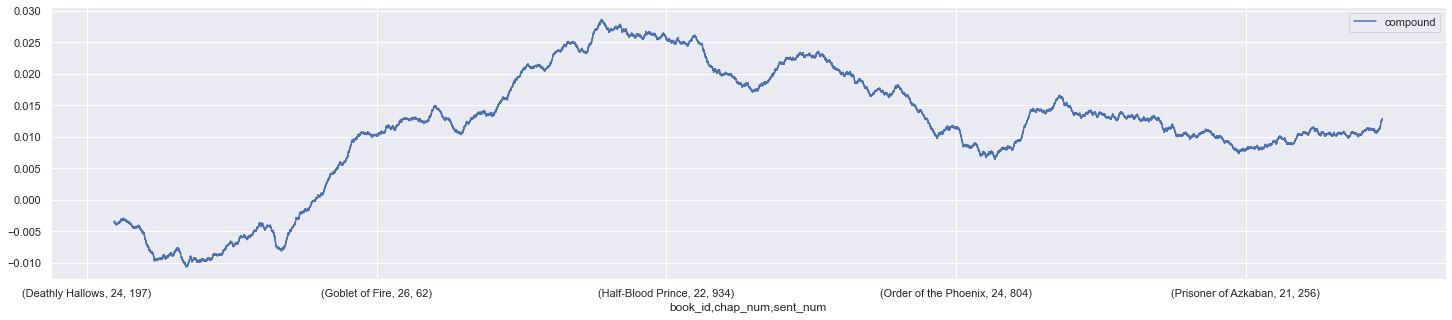

In [167]:
w = int(TOKENS_vader.shape[0] / 5)
TOKENS_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
TOKENS_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
TOKENS_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

In [168]:
SALEX = salex
V = pd.concat([vocab.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

In [169]:
V.head()

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
harry,17321,5,0.015655,5.997275,8,NNP,0,harri,harri,harry,...,0,0,0,0,1,0,1,0,0,-1
professor,1962,9,0.001773,9.139400,6,NNP,0,professor,professor,profess,...,0,0,0,0,0,1,0,0,1,1
don,1172,3,0.001059,9.882753,4,NN,1,don,don,don,...,0,0,0,0,0,1,0,0,1,1
good,1035,4,0.000935,10.062094,4,JJ,0,good,good,good,...,1,0,0,1,0,1,0,1,1,1
black,947,5,0.000856,10.190289,5,JJ,0,black,black,black,...,0,0,0,0,1,0,1,0,0,-1


In [170]:
B = V.copy()
for col in emo_cols:
    B[col] = B[col] * B.tfidf
B.head()

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
harry,17321,5,0.015655,5.997275,8,NNP,0,harri,harri,harry,...,0.000000,0.0,0.0,0.000000,1,0,0.109582,0.000000,0.000000,-0.109582
professor,1962,9,0.001773,9.139400,6,NNP,0,professor,professor,profess,...,0.000000,0.0,0.0,0.000000,0,1,0.000000,0.000000,0.012413,0.012413
don,1172,3,0.001059,9.882753,4,NN,1,don,don,don,...,0.000000,0.0,0.0,0.000000,0,1,0.000000,0.000000,0.007415,0.007415
good,1035,4,0.000935,10.062094,4,JJ,0,good,good,good,...,0.006548,0.0,0.0,0.006548,0,1,0.000000,0.006548,0.006548,0.006548
black,947,5,0.000856,10.190289,5,JJ,0,black,black,black,...,0.000000,0.0,0.0,0.000000,1,0,0.005991,0.000000,0.000000,-0.005991


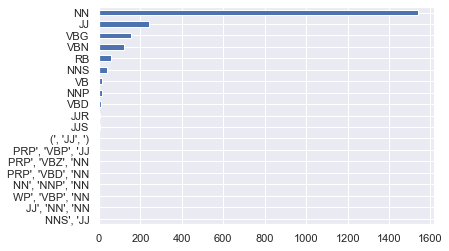

In [171]:
B.max_pos.value_counts().sort_values().plot.barh();

In [172]:
B

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
harry,17321,5,1.565454e-02,5.997275,8,NNP,0,harri,harri,harry,...,0.000000,0.000000e+00,0.000000e+00,0.000000,1,0,1.095818e-01,0.000000,0.000000,-1.095818e-01
professor,1962,9,1.773236e-03,9.139400,6,NNP,0,professor,professor,profess,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0,1,0.000000e+00,0.000000,0.012413,1.241265e-02
don,1172,3,1.059242e-03,9.882753,4,NN,1,don,don,don,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0,1,0.000000e+00,0.000000,0.007415,7.414691e-03
good,1035,4,9.354224e-04,10.062094,4,JJ,0,good,good,good,...,0.006548,0.000000e+00,0.000000e+00,0.006548,0,1,0.000000e+00,0.006548,0.006548,6.547957e-03
black,947,5,8.558889e-04,10.190289,5,JJ,0,black,black,black,...,0.000000,0.000000e+00,0.000000e+00,0.000000,1,0,5.991222e-03,0.000000,0.000000,-5.991222e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muzzle,1,6,9.037898e-07,20.077509,1,NN,0,muzzl,muzzl,muzzl,...,0.000000,0.000000e+00,9.037898e-07,0.000000,1,0,0.000000e+00,0.000000,0.000000,-9.037898e-07
lunacy,1,6,9.037898e-07,20.077509,1,NN,0,lunaci,lunaci,lun,...,0.000000,9.037898e-07,9.037898e-07,0.000000,1,0,9.037898e-07,0.000000,0.000000,-9.037898e-07
thoughtless,1,11,9.037898e-07,20.077509,1,NN,0,thoughtless,thoughtless,thoughtless,...,0.000000,9.037898e-07,0.000000e+00,0.000000,1,0,0.000000e+00,0.000000,0.000000,-9.037898e-07


In [173]:
BOW_books

n
book_id            term_str        
Chamber of Secrets 1              3
                   11             3
                   12             1
                   1289           1
                   13             1
...                              ..
Sorcerer's Stone   zoo            5
                   zoom           1
                   zoomed         1
                   zooming        2
                   zoorestaurant  1

[71628 rows x 1 columns]

In [174]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()
EMO_BOOKS.index = LIB.title
EMO_BOOKS.plot.barh(figsize=(15,30));

KeyError: 'book_id'

### Compare texts

In [ ]:
HPONE = EMO_CHAPS.loc['Chamber of Secrets'].copy()
HPSEVEN = EMO_CHAPS.loc['The Deathly Hallows'].copy()

NameError: name 'EMO_CHAPS' is not defined

In [ ]:
HPONE.mean().sort_values().plot.barh();

In [ ]:
HPSEVEN.mean().sort_values().plot.barh();

NameError: name 'HPSEVEN' is not defined

# CHECKING REQUIRED TABLES

In [235]:
LIB.columns

Index(['source_file_path', 'author', 'title', 'n_tokens', 'n_chapters',
       'n_sentences', 'label', 'genre'],
      dtype='object')

In [175]:
LIB

,source_file_path,author,title,n_tokens,n_chapters,n_sentences,label,genre
book_id,,,,,,,,
Sorcerer's Stone,hp1.txt,JK Rowling,Sorcerer's Stone,79970,17,8100,hp1,nonfiction
Chamber of Secrets,hp2.txt,JK Rowling,Chamber of Secrets,89647,18,7330,hp2,nonfiction
Prisoner of Azkaban,hp3.txt,JK Rowling,Prisoner of Azkaban,107506,22,11683,hp3,nonfiction
Goblet of Fire,hp4.txt,JK Rowling,Goblet of Fire,198594,37,20095,hp4,nonfiction
Order of the Phoenix,hp5.txt,JK Rowling,Order of the Phoenix,263251,38,25729,hp5,nonfiction
Half-Blood Prince,hp6.txt,JK Rowling,Half-Blood Prince,185082,30,16815,hp6,nonfiction
Deathly Hallows,hp7.txt,JK Rowling,Deathly Hallows,203899,37,19841,hp7,nonfiction


In [176]:
CORPUS = CORPUS.merge(vocab, left_on='term_str', right_index=True, how='left')

In [177]:
CORPUS

token_str term_str pos_tuple  \
book_id          chap_num sent_num token_num                                
Sorcerer's Stone 1        0        0                Mr       mr     (NN,)   
                          1        0               and      and     (CC,)   
                                   1               Mrs      mrs     (NN,)   
                          2        0           Dursley  dursley     (NN,)   
                                   1                of       of     (IN,)   
...                                                ...      ...       ...   
Deathly Hallows  37       263      0               All      all     (DT,)   
                                   1               was      was    (VBD,)   
                                   2              well     well     (RB,)   
                          264      0               THE      the     (DT,)   
                                   1               END      end     (NN,)   

                                                pos      n  n_chars         p  \
book_id          chap_num sent_num token_num                                    
Sorcerer's Stone 1        0        0           [NN]   1276        2  0.001153   
                          1        0           [CC]  27136        3  0.024525   
                                   1           [NN]    876        3  0.000792   
                          2        0           [NN]     86        7  0.000078   
                                   1           [IN]  21615        2  0.019535   
...                                             ...    ...      ...       ...   
Deathly Hallows  37       263      0           [DT]   4316        3  0.003901   
                                   1          [VBD]  15405        3  0.013923   
                                   2           [RB]   2109        4  0.001906   
                          264      0           [DT]  50990        3  0.046084   
                                   1           [NN]    569        3  0.000514   

                                                      i  n_pos max_pos  ...  \
book_id          chap_num sent_num token_num                            ...   
Sorcerer's Stone 1        0        0           9.760097      3      NN  ...   
                          1        0           5.349589      5      CC  ...   
                                   1          10.302722      1      NN  ...   
                          2        0          13.651245      1      NN  ...   
                                   1           5.677764      3      IN  ...   
...                                                 ...    ...     ...  ...   
Deathly Hallows  37       263      0           8.002030      4      DT  ...   
                                   1           6.166398      7     VBD  ...   
                                   2           9.035166      7      RB  ...   
                          264      0           4.439583      4      DT  ...   
                                   1          10.925225      1      NN  ...   

                                              stem_snowball stem_lancaster  \
book_id          chap_num sent_num token_num                                 
Sorcerer's Stone 1        0        0                     mr             mr   
                          1        0                    and            and   
                                   1                    mrs            mrs   
                          2        0                dursley        dursley   
                                   1                     of             of   
...                                                     ...            ...   
Deathly Hallows  37       263      0                    all             al   
                                   1                    was            was   
                                   2                   well            wel   
                          264      0                    the            the   
                         

In [244]:
# CORPUS.to_csv('CORPUS_hp.csv', index=True)

## Getting TFIDF Stuff

### TF

In [178]:
BOW = BOW_sents.copy()

In [179]:
TOKEN = TOKENS.copy()

In [180]:
BOW = TOKEN.groupby(CHAPS+['term_str']).term_str.count().to_frame('n') 

In [181]:
BOW.head()

n
book_id            chap_num term_str       
Chamber of Secrets 1        11            2
                            a            46
                            abnormality   1
                            about         8
                            absent        1

In [182]:
DTCM = BOW.n.unstack().fillna(0).astype('int')

In [183]:
DTCM.head(10)

term_str                     0  0111  1  10  100  100snape  101  102  104  \
book_id            chap_num                                                 
Chamber of Secrets 1         0     0  0   0    0         0    0    0    0   
                   2         0     0  0   0    0         0    0    0    0   
                   3         0     0  0   0    0         0    0    0    0   
                   4         0     0  0   0    0         0    0    0    0   
                   5         0     0  0   0    0         0    0    0    0   
                   6         0     0  1   0    0         0    0    0    0   
                   7         0     0  0   0    0         0    0    0    0   
                   8         0     0  2   0    0         0    0    0    0   
                   9         0     0  0   0    0         0    0    0    0   
                   10        0     0  0   0    0         0    0    0    0   

term_str                     104at  ...  zone  zonko  zonkos  zoo  zoological  \
book_id            chap_num         ...                                         
Chamber of Secrets 1             0  ...     0      0       0    0           0   
                   2             0  ...     0      0       0    1           0   
                   3             0  ...     0      0       0    0           0   
                   4             0  ...     0      0       0    0           0   
                   5             0  ...     0      0       0    0           0   
                   6             0  ...     0      0       0    0           0   
                   7             0  ...     0      0       0    0           0   
                   8             0  ...     0      0       0    0           0   
                   9             0  ...     0      0       0    0           0   
                   10            0  ...     0      0       0    0           0   

term_str                     zoom  zoomed  zoomign  zooming  zoorestaurant  
book_id            chap_num                                                 
Chamber of Secrets 1            0       0        0        0              0  
                   2            0       0        0        0              0  
                   3            0       0        0        0              0  
                   4            0       0        0        0              0  
                   5            0       0        0        0              0  
                   6            0       0        0        0              0  
                   7            0       0        0        0              0  
                   8            0       0        0        0              0  
                   9            0       0        0        0              0  
                   10           0       1        0        0              0  

[10 rows x 29175 columns]

In [184]:
DOC = DTCM.sum(1).to_frame('n_tokens')
DOC['n_types'] = DTCM.astype('bool').sum(1)

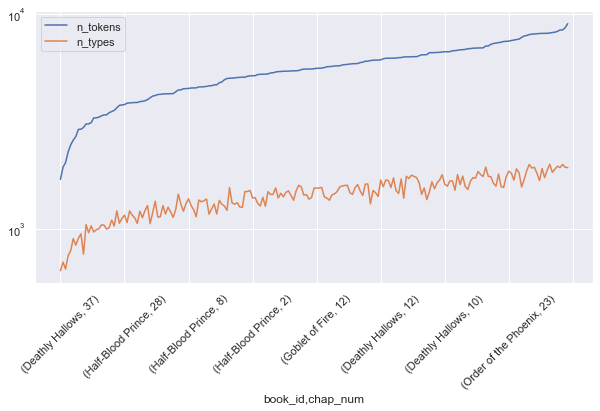

In [185]:
DOC.sort_values('n_tokens').plot(logy=True, figsize=(10, 5), rot=45);

In [186]:
tf_method = 'sum'
print('TF method:', tf_method)
if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

TF method: sum


In [187]:
DF = DTCM.astype('bool').sum()

In [188]:
N = DTCM.shape[0]

In [189]:
idf_method = 'standard'
print('IDF method:', idf_method)
if idf_method == 'standard':
    IDF = np.log2(N / DF)
elif idf_method == 'max':
    IDF = np.log2(DF.max() / DF) 
elif idf_method == 'smooth':
    IDF = np.log2((1 + N) / (1 + DF)) + 1

IDF method: standard


In [190]:
TFIDF = TF * IDF

In [191]:
TFIDF.head()

term_str                       0  0111    1   10  100  100snape  101  102  \
book_id            chap_num                                                 
Chamber of Secrets 1         0.0   0.0  0.0  0.0  0.0       0.0  0.0  0.0   
                   2         0.0   0.0  0.0  0.0  0.0       0.0  0.0  0.0   
                   3         0.0   0.0  0.0  0.0  0.0       0.0  0.0  0.0   
                   4         0.0   0.0  0.0  0.0  0.0       0.0  0.0  0.0   
                   5         0.0   0.0  0.0  0.0  0.0       0.0  0.0  0.0   

term_str                     104  104at  ...  zone  zonko  zonkos       zoo  \
book_id            chap_num              ...                                  
Chamber of Secrets 1         0.0    0.0  ...   0.0    0.0     0.0  0.000000   
                   2         0.0    0.0  ...   0.0    0.0     0.0  0.001939   
                   3         0.0    0.0  ...   0.0    0.0     0.0  0.000000   
                   4         0.0    0.0  ...   0.0    0.0     0.0  0.000000   
                   5         0.0    0.0  ...   0.0    0.0     0.0  0.000000   

term_str                     zoological  zoom  zoomed  zoomign  zooming  \
book_id            chap_num                                               
Chamber of Secrets 1                0.0   0.0     0.0      0.0      0.0   
                   2                0.0   0.0     0.0      0.0      0.0   
                   3                0.0   0.0     0.0      0.0      0.0   
                   4                0.0   0.0     0.0      0.0      0.0   
                   5                0.0   0.0     0.0      0.0      0.0   

term_str                     zoorestaurant  
book_id            chap_num                 
Chamber of Secrets 1                   0.0  
                   2                   0.0  
                   3                   0.0  
                   4                   0.0  
                   5                   0.0  

[5 rows x 29175 columns]

In [192]:
VOCAB3 = VOCAB.copy()
VOCAB3['df'] = DF
VOCAB3['idf'] = IDF

In [193]:
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

In [194]:
VOCAB3['tfidf_mean'] = TFIDF.mean() 
VOCAB3['tfidf_sum'] = TFIDF.sum()
VOCAB3['tfidf_median'] = TFIDF.median()
VOCAB3['tfidf_max'] = TFIDF.max()

In [195]:
VOCAB3.tfidf_mean

term_str
the             0.000000
and             0.000000
to              0.000000
of              0.000000
he              0.000000
                  ...   
buthow          0.000005
itlight         0.000005
344             0.000005
searchingfor    0.000005
bereavement     0.000023
Name: tfidf_mean, Length: 29175, dtype: float64

In [196]:
VOCAB3['dfidf'] = VOCAB3.df * VOCAB3.idf

In [197]:
VOCAB3['dp'] = VOCAB3.df / len(DOC)

In [198]:
VOCAB3['dh'] = VOCAB3.dp * np.log2(1/VOCAB3.dp)

In [199]:
VOCAB3

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,df,idf,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max,dfidf,dp,dh
term_str,,,,,,,,,,,,,,,,,,,
the,50990,3,4.608424e-02,4.439583,4,DT,1,the,the,the,199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
and,27136,3,2.452524e-02,5.349589,5,CC,1,and,and,and,199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
to,26780,2,2.420349e-02,5.368641,5,TO,1,to,to,to,199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
of,21615,2,1.953542e-02,5.677764,3,IN,1,of,of,of,199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
he,21442,2,1.937906e-02,5.689358,4,PRP,1,he,he,he,199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
buthow,1,6,9.037898e-07,20.077509,1,NN,0,buthow,buthow,buthow,1,7.636625,0.000005,0.001034,0.0,0.001034,7.636625,0.005025,0.038375
itlight,1,7,9.037898e-07,20.077509,1,NN,0,itlight,itlight,itlight,1,7.636625,0.000005,0.001034,0.0,0.001034,7.636625,0.005025,0.038375
344,1,3,9.037898e-07,20.077509,1,CD,0,344,344,344,1,7.636625,0.000005,0.001034,0.0,0.001034,7.636625,0.005025,0.038375


In [200]:
vocab

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,p2,h,tf,num_books,num_chaps,num_sents,idf,tfidf
term_str,,,,,,,,,,,,,,,,,,
the,50990,3,4.608424e-02,4.439583,4,DT,1,the,the,the,1.747729,0.204595,4.608424e-02,7,38,1242,1.0,3.225897e-01
and,27136,3,2.452524e-02,5.349589,5,CC,1,and,and,and,0.930111,0.131200,2.452524e-02,7,38,1197,1.0,1.716767e-01
to,26780,2,2.420349e-02,5.368641,5,TO,1,to,to,to,0.917909,0.129940,2.420349e-02,7,38,1187,1.0,1.694244e-01
of,21615,2,1.953542e-02,5.677764,3,IN,1,of,of,of,0.740874,0.110917,1.953542e-02,7,38,1169,1.0,1.367479e-01
he,21442,2,1.937906e-02,5.689358,4,PRP,1,he,he,he,0.734944,0.110254,1.937906e-02,7,38,1176,1.0,1.356534e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
buthow,1,6,9.037898e-07,20.077509,1,NN,0,buthow,buthow,buthow,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
itlight,1,7,9.037898e-07,20.077509,1,NN,0,itlight,itlight,itlight,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
344,1,3,9.037898e-07,20.077509,1,CD,0,344,344,344,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07


In [201]:
#VOCAB3 = VOCAB3.join(vocab, how='left')
VOCAB3 = pd.merge(VOCAB3, vocab, on='term_str')

In [203]:
gradient_cmap = 'YlGnBu'
VOCAB3.sample(50).sort_values('i', ascending=True)[['max_pos', 'i','tfidf_mean','tfidf_median','tfidf_max', 'dfidf', 'dh']].style.background_gradient(cmap=gradient_cmap)


KeyError: 'i'

In [204]:
px.scatter(VOCAB3.reset_index(), x='i', y='tfidf_mean', hover_name='term_str', hover_data=['n'], color='max_pos', 
           log_x=False, log_y=False)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x', 'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x', 'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp', 'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y', 'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2', 'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'] but received: i

In [ ]:
px.scatter(VOCAB3.reset_index(), x='i', y='tfidf_median', hover_name='term_str', hover_data=['n'], color='max_pos', 
           log_x=False, log_y=False)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x', 'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x', 'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp', 'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y', 'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2', 'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'] but received: i

In [205]:
px.scatter(VOCAB3.reset_index(), x='i', y='tfidf_max', hover_name='term_str', hover_data=['n'], color='max_pos', 
           log_x=False, log_y=False)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x', 'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x', 'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp', 'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y', 'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2', 'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'] but received: i

In [ ]:
px.scatter(VOCAB3.reset_index(), x='i', y='tfidf_sum', hover_name='term_str', hover_data=['n'], color='max_pos')


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x', 'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x', 'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp', 'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y', 'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2', 'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'] but received: i

In [206]:
px.scatter(VOCAB3.reset_index(), x='i', y='dh', hover_name='term_str', hover_data=['n'], color='max_pos', height=800)


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x', 'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x', 'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp', 'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y', 'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2', 'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'] but received: i

In [207]:
VOCAB3

,n_x,n_chars_x,p_x,i_x,n_pos_x,max_pos_x,stop_x,stem_porter_x,stem_snowball_x,stem_lancaster_x,...,stem_snowball_y,stem_lancaster_y,p2,h,tf,num_books,num_chaps,num_sents,idf_y,tfidf
term_str,,,,,,,,,,,,,,,,,,,,,
the,50990,3,4.608424e-02,4.439583,4,DT,1,the,the,the,...,the,the,1.747729,0.204595,4.608424e-02,7,38,1242,1.0,3.225897e-01
and,27136,3,2.452524e-02,5.349589,5,CC,1,and,and,and,...,and,and,0.930111,0.131200,2.452524e-02,7,38,1197,1.0,1.716767e-01
to,26780,2,2.420349e-02,5.368641,5,TO,1,to,to,to,...,to,to,0.917909,0.129940,2.420349e-02,7,38,1187,1.0,1.694244e-01
of,21615,2,1.953542e-02,5.677764,3,IN,1,of,of,of,...,of,of,0.740874,0.110917,1.953542e-02,7,38,1169,1.0,1.367479e-01
he,21442,2,1.937906e-02,5.689358,4,PRP,1,he,he,he,...,he,he,0.734944,0.110254,1.937906e-02,7,38,1176,1.0,1.356534e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
buthow,1,6,9.037898e-07,20.077509,1,NN,0,buthow,buthow,buthow,...,buthow,buthow,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
itlight,1,7,9.037898e-07,20.077509,1,NN,0,itlight,itlight,itlight,...,itlight,itlight,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07
344,1,3,9.037898e-07,20.077509,1,CD,0,344,344,344,...,344,344,0.000034,0.000018,9.037898e-07,1,1,1,7.0,9.037898e-07


### Download vocab 3 (has statistical stuff added)

In [242]:
# download vocab 3

# VOCAB3.to_csv('VOCAB_hp.csv', index=True)

In [218]:
VOCAB3.columns

Index(['n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x',
       'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x',
       'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp',
       'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y',
       'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2',
       'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'],
      dtype='object')

### download loadings as CSV


In [237]:
# Download loadings as CSV

# LOADINGS.to_csv('LOADINGS_hp.csv', index=True)

In [208]:
LOADINGS

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
slughorn,-0.097107,0.480736,-0.127932,-0.018074,-0.087341,-0.019101,0.000000,0.000000,0.000000,0.000000
dont,0.333939,-0.060170,-0.017345,-0.020027,-0.037691,-0.037966,-0.000632,0.002032,0.000257,0.000334
lupin,-0.136479,-0.171287,-0.170713,0.486881,0.010634,0.018100,-0.000153,0.000042,-0.000490,0.000203
umbridge,0.256725,-0.038707,-0.024052,0.030346,0.041544,-0.586553,-0.000627,0.000328,-0.001222,0.000030
ng,-0.062198,0.287182,-0.074915,-0.011084,-0.066037,-0.019000,0.000109,-0.003467,-0.000131,0.000130
...,...,...,...,...,...,...,...,...,...,...
hunt,0.003000,-0.000584,-0.001011,0.001439,-0.004479,0.005628,0.054990,-0.006028,-0.005029,-0.059729
triangular,0.003750,0.000868,0.000072,0.000247,0.014733,0.007957,0.021353,0.037580,-0.026492,-0.041392
startled,-0.002001,-0.000843,-0.001756,0.002687,0.001593,-0.000614,0.007695,-0.002662,-0.030387,-0.087434


In [209]:
PHI

term_str,aback,abbott,aberforth,ability,abou,abrupt,absence,absent,absolute,accept,...,youth,youve,yule,yule ball,zabini,zacharias,zat,ze,zero,zonko
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,1.483305,0.025000,0.025000,0.025000,0.025000,2.652532,0.025000,0.025000,0.025000,5.618741,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.234451,0.025000,0.025000,0.025
T01,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T02,0.025000,0.025000,0.025000,1.033331,0.025000,2.563070,0.025000,0.025000,0.025000,2.207575,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T03,1.067371,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,1.820505,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T04,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T05,1.891669,0.025000,0.025000,3.159673,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T06,1.098753,0.025000,0.025000,1.360794,2.363524,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T07,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025
T08,0.679389,0.025000,0.025000,0.025000,0.025000,0.025000,2.355251,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025


In [210]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,dumbledore,snape,mcgonagall,voldemort,think,eyes,room,hogwarts,school,"T00 dumbledore, snape, mcgonagall, voldemort, ...",9.544430,0.049369
T01,aback,pro,presents,press,pressure,pretend,prevent,price,pride,"T01 aback, pro, presents, press, pressure, pre...",0.003764,0.000344
T02,uncle,vernon,uncle vernon,dudley,aunt,petunia,aunt petunia,dursleys,house,"T02 uncle, vernon, uncle vernon, dudley, aunt,...",10.672525,0.042316
T03,dumbledore,mrs,mr,dementors,voice,malfoy,witch,lucius,mr malfoy,"T03 dumbledore, mrs, mr, dementors, voice, mal...",2.290607,0.010064
T04,dumbledore,water,rock,lake,potion,surface,goblet,light,boat,"T04 dumbledore, water, rock, lake, potion, sur...",1.024127,0.005648
T05,voldemort,horcrux,dumbledore,horcruxes,tent,locket,sword,knew,slughorn,"T05 voldemort, horcrux, dumbledore, horcruxes,...",2.816216,0.014324
T06,umbridge,dumbledore,fudge,firenze,centaurs,centaur,head,floor,face,"T06 umbridge, dumbledore, fudge, firenze, cent...",1.252934,0.007491
T07,voldemort,wand,death,cedric,eaters,death eaters,light,voldemort wand,hand,"T07 voldemort, wand, death, cedric, eaters, de...",1.162909,0.003851
T08,ron,hall,dumbledore,students,table,hermione,mcgonagall,gryffindor,hat,"T08 ron, hall, dumbledore, students, table, he...",6.620644,0.034079


In [211]:
coords

,vector,x,y,n,n_chars,p,i,n_pos,max_pos_x,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_y,tfidf,pos_max
term_str,,,,,,,,,,,,,,,,
s,"[-0.11298585, 0.0065220254, 0.08439004, -0.182...",34.372070,-6.260707,8128,1,0.007346,7.088825,3,NN,1,s,s,s,NN,0.051422,NN
ron,"[0.2947893, 0.12605256, 0.17766315, -0.6940048...",-1.357736,-25.207333,6017,3,0.005438,7.522681,5,NN,0,ron,ron,ron,NN,0.038067,NN
hermione,"[0.19096102, 0.12453712, 0.112152696, -0.55245...",-1.184428,-24.997581,5051,8,0.004565,7.775156,4,NN,0,hermion,hermion,herm,NN,0.031955,NN
t,"[-0.49767983, 0.2060233, 0.9944709, -0.2582947...",47.656403,0.831097,4876,1,0.004407,7.826027,5,NN,1,t,t,t,NN,0.030848,NN
dumbledore,"[-0.59499985, -0.30767766, -0.08050824, 0.1975...",32.613766,17.267717,3041,10,0.002748,8.507179,2,NN,0,dumbledor,dumbledor,dumbl,NN,0.019239,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seventeen,"[-0.15572235, -0.023258863, -0.05557381, 0.019...",14.842168,7.911807,50,9,0.000045,14.433653,1,NN,0,seventeen,seventeen,seventeen,NN,0.000271,NN
pretend,"[-0.17037842, -0.0042274357, -0.061342422, -0....",9.256346,1.135684,51,7,0.000046,14.405084,2,NN,0,pretend,pretend,pretend,NN,0.000323,NN
rise,"[-0.19570759, -0.0054873554, -0.13003674, 0.12...",-15.212090,12.312825,50,4,0.000045,14.433653,1,NN,0,rise,rise,ris,NN,0.000271,NN


### download coords to csv

In [241]:
# download coords to csv
# coords.to_csv('coords_hp.csv', index=True)

In [212]:
salex

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [213]:
B

,n,n_chars,p,i,n_pos,max_pos,stop,stem_porter,stem_snowball,stem_lancaster,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
harry,17321,5,1.565454e-02,5.997275,8,NNP,0,harri,harri,harry,...,0.000000,0.000000e+00,0.000000e+00,0.000000,1,0,1.095818e-01,0.000000,0.000000,-1.095818e-01
professor,1962,9,1.773236e-03,9.139400,6,NNP,0,professor,professor,profess,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0,1,0.000000e+00,0.000000,0.012413,1.241265e-02
don,1172,3,1.059242e-03,9.882753,4,NN,1,don,don,don,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0,1,0.000000e+00,0.000000,0.007415,7.414691e-03
good,1035,4,9.354224e-04,10.062094,4,JJ,0,good,good,good,...,0.006548,0.000000e+00,0.000000e+00,0.006548,0,1,0.000000e+00,0.006548,0.006548,6.547957e-03
black,947,5,8.558889e-04,10.190289,5,JJ,0,black,black,black,...,0.000000,0.000000e+00,0.000000e+00,0.000000,1,0,5.991222e-03,0.000000,0.000000,-5.991222e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muzzle,1,6,9.037898e-07,20.077509,1,NN,0,muzzl,muzzl,muzzl,...,0.000000,0.000000e+00,9.037898e-07,0.000000,1,0,0.000000e+00,0.000000,0.000000,-9.037898e-07
lunacy,1,6,9.037898e-07,20.077509,1,NN,0,lunaci,lunaci,lun,...,0.000000,9.037898e-07,9.037898e-07,0.000000,1,0,9.037898e-07,0.000000,0.000000,-9.037898e-07
thoughtless,1,11,9.037898e-07,20.077509,1,NN,0,thoughtless,thoughtless,thoughtless,...,0.000000,9.037898e-07,0.000000e+00,0.000000,1,0,0.000000e+00,0.000000,0.000000,-9.037898e-07


In [226]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [227]:
salex

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [228]:
salex.columns

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'sentiment'],
      dtype='object')

In [229]:
SALEX.columns

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'sentiment'],
      dtype='object')

In [230]:
B.columns

Index(['n', 'n_chars', 'p', 'i', 'n_pos', 'max_pos', 'stop', 'stem_porter',
       'stem_snowball', 'stem_lancaster', 'p2', 'h', 'tf', 'num_books',
       'num_chaps', 'num_sents', 'idf', 'tfidf', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise',
       'trust', 'sentiment'],
      dtype='object')

### download B as csv (it is for sentiment analysis)

In [240]:
# download sentiment analysis csv

# B.to_csv('SENTIMENT_hp.csv', index=True)

In [236]:
VOCAB3.columns

Index(['n_x', 'n_chars_x', 'p_x', 'i_x', 'n_pos_x', 'max_pos_x', 'stop_x',
       'stem_porter_x', 'stem_snowball_x', 'stem_lancaster_x', 'df', 'idf_x',
       'tfidf_mean', 'tfidf_sum', 'tfidf_median', 'tfidf_max', 'dfidf', 'dp',
       'dh', 'n_y', 'n_chars_y', 'p_y', 'i_y', 'n_pos_y', 'max_pos_y',
       'stop_y', 'stem_porter_y', 'stem_snowball_y', 'stem_lancaster_y', 'p2',
       'h', 'tf', 'num_books', 'num_chaps', 'num_sents', 'idf_y', 'tfidf'],
      dtype='object')